<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Ames Housing Data and Kaggle Challenge

Contents:

- [Part 0: Python Imports](Part_0:_Python_Imports)
- [Part 1: Data Imports](Part_1:_Data_Imports)
- [Part 2: EDA, Preliminary Data Cleaning & Visualizations](Part_2:_EDA,_Preliminary_Data_Cleaning_&_Visualizations)
- [Part 3: Feature Engineering](Part_3:_Feature_Engineering)
- [Part 4: Modeling](Part_4:_Modeling)
- [Part 5: Predictions](Part_5:_Predictions)

## Part 0: Python Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from scipy.stats import kstest

%config InlineBackend.figure_format = 'retina'

## Part 1: Data Imports

In [2]:
train_data = pd.read_csv('datasets/train.csv')
test_data = pd.read_csv('datasets/test.csv')
#sample_data = pd.read_csv('datasets/sample_sub_reg.csv')

train_data.shape

(2051, 81)

In [3]:
test_data.shape # one less column (dependent var) and about 30% of total dataset

(878, 80)

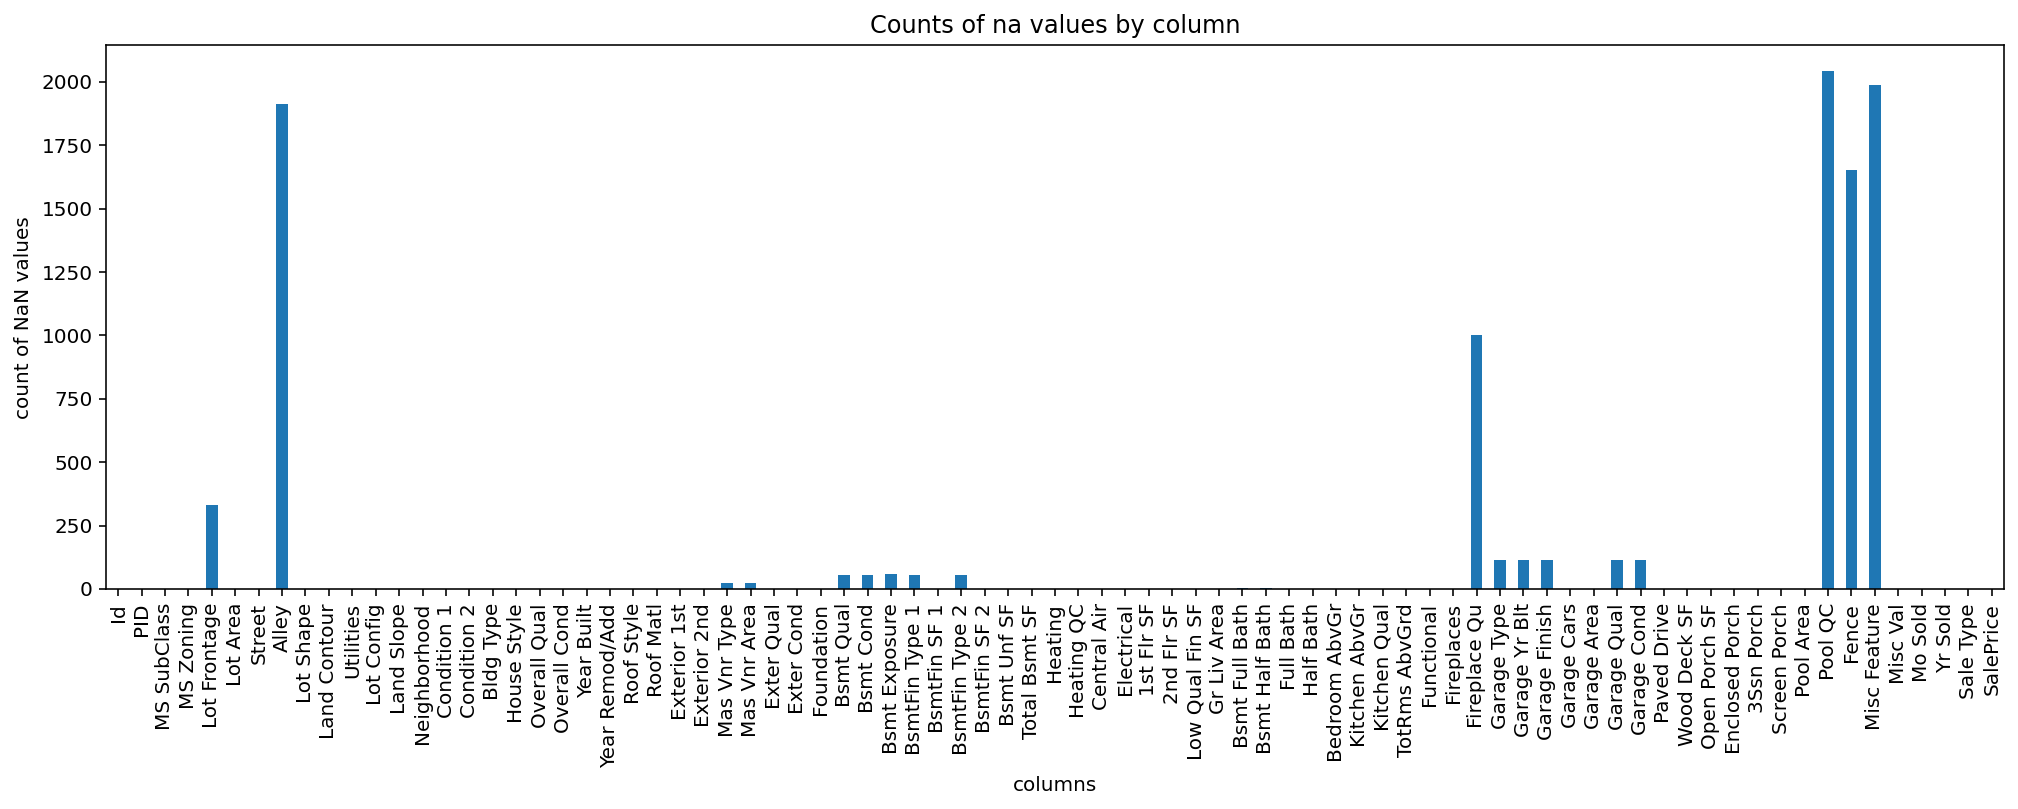

In [4]:
plt.figure(figsize = (17,5))
train_data.isna().sum().plot(kind = 'bar')
plt.xlabel('columns')
plt.ylabel('count of NaN values')
plt.title('Counts of na values by column');

In [5]:
# removing columns with at least 50% missing values (there are plenty features with complete info to choose from)
train_data.dropna(axis = 1, thresh = 0.5*len(train_data), inplace = True)
train_data.shape

(2051, 77)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 77 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Lot Shape        2051 non-null   object 
 8   Land Contour     2051 non-null   object 
 9   Utilities        2051 non-null   object 
 10  Lot Config       2051 non-null   object 
 11  Land Slope       2051 non-null   object 
 12  Neighborhood     2051 non-null   object 
 13  Condition 1      2051 non-null   object 
 14  Condition 2      2051 non-null   object 
 15  Bldg Type        2051 non-null   object 
 16  House Style      2051 non-null   object 
 17  Overall Qual  

## Part 2: EDA, Preliminary Data Cleaning & Visualizations

In [7]:
# copying original train data to analyze as I evolve my model:
train_data_orig = pd.read_csv('datasets/train.csv')
train_data_orig['USD_per_sqft'] = train_data_orig['SalePrice']/train_data['Gr Liv Area']

**Examining distribution of target variable(`SalePrice`)**

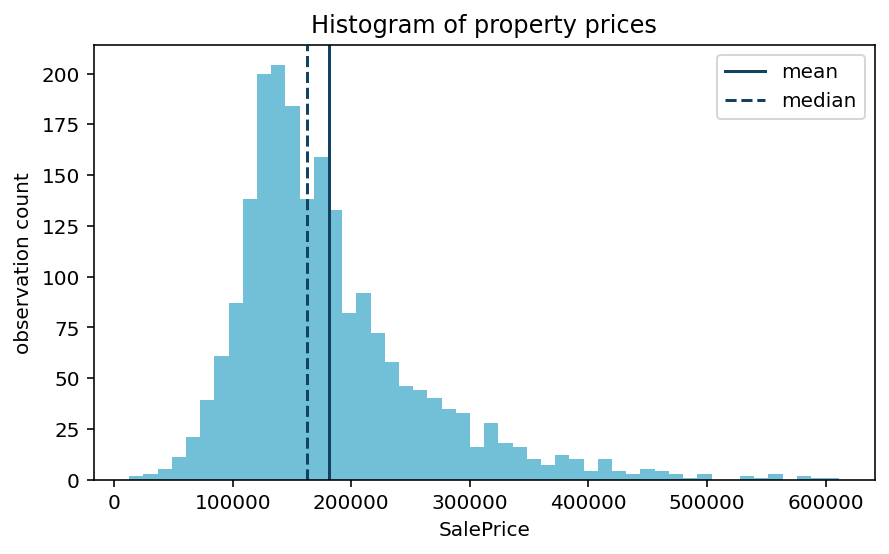

In [8]:
plt.figure(figsize=(7,4))
plt.title('Histogram of property prices')
plt.hist(train_data_orig['SalePrice'], bins = 50, color = '#1595bfff', alpha = 0.6)
plt.xlabel('SalePrice')
plt.ylabel('observation count')
plt.axvline(train_data_orig['SalePrice'].mean(), color = '#114262ff', label = 'mean')
plt.axvline(train_data_orig['SalePrice'].median(), color = '#114262ff', ls = '--', label = 'median')
plt.legend()
plt.savefig('./visualizations/SalePrice_hist.png');

**_Observation:_** The dependent variable (`SalePrice`) has a right skew - while the mean and median both fall in the USD 150k-USD 200k range, a handful of the houses included in the dataset are priced at over $400,000.

**Exploring characteristics of observations with target variable(`SalePrice`)>$400,000 (the long tail)**

In [9]:
train_data_orig[train_data_orig['SalePrice']>400000].describe().T

count          mean           std           min  \
Id                46.0  1.308674e+03  8.274475e+02  1.600000e+01   
PID               46.0  5.695168e+08  1.203635e+08  5.272100e+08   
MS SubClass       46.0  4.043478e+01  2.094506e+01  2.000000e+01   
Lot Frontage      44.0  9.134091e+01  2.509048e+01  4.700000e+01   
Lot Area          46.0  1.699502e+04  9.306099e+03  1.055700e+04   
Overall Qual      46.0  9.043478e+00  8.421275e-01  6.000000e+00   
Overall Cond      46.0  5.195652e+00  7.780193e-01  5.000000e+00   
Year Built        46.0  2.000348e+03  1.973628e+01  1.892000e+03   
Year Remod/Add    46.0  2.004500e+03  4.801620e+00  1.990000e+03   
Mas Vnr Area      45.0  5.198444e+02  2.843305e+02  0.000000e+00   
BsmtFin SF 1      46.0  1.140326e+03  6.589986e+02  0.000000e+00   
BsmtFin SF 2      46.0  5.667391e+01  2.290389e+02  0.000000e+00   
Bsmt Unf SF       46.0  7.864783e+02  5.890151e+02  4.800000e+01   
Total Bsmt SF     46.0  1.983478e+03  4.616827e+02  1.107000e+03   
1st Flr SF        46.0  1.992783e+03  3.929840e+02  1.414000e+03   
2nd Flr SF        46.0  5.997609e+02  6.555515e+02  0.000000e+00   
Low Qual Fin SF   46.0  1.243478e+01  8.433680e+01  0.000000e+00   
Gr Liv Area       46.0  2.604978e+03  4.659885e+02  1.868000e+03   
Bsmt Full Bath    46.0  8.478261e-01  4.698648e-01  0.000000e+00   
Bsmt Half Bath    46.0  0.000000e+00  0.000000e+00  0.000000e+00   
Full Bath         46.0  2.195652e+00  4.531159e-01  1.000000e+00   
Half Bath         46.0  7.391304e-01  4.439611e-01  0.000000e+00   
Bedroom AbvGr     46.0  3.152174e+00  9.880934e-01  1.000000e+00   
Kitchen AbvGr     46.0  1.000000e+00  0.000000e+00  1.000000e+00   
TotRms AbvGrd     46.0  9.195652e+00  1.586324e+00  7.000000e+00   
Fireplaces        46.0  1.260870e+00  4.439611e-01  1.000000e+00   
Garage Yr Blt     46.0  2.003935e+03  4.950431e+00  1.992000e+03   
Garage Cars       46.0  2.956522e+00  2.948839e-01  2.000000e+00   
Garage Area       46.0  8.482174e+02  1.607218e+02  5.460000e+02   
Wood Deck SF      46.0  2.090217e+02  1.875846e+02  0.000000e+00   
Open Porch SF     46.0  9.573913e+01  7.004235e+01  0.000000e+00   
Enclosed Porch    46.0  1.373913e+01  5.251346e+01  0.000000e+00   
3Ssn Porch        46.0  0.000000e+00  0.000000e+00  0.000000e+00   
Screen Porch      46.0  5.669565e+01  1.038349e+02  0.000000e+00   
Pool Area         46.0  0.000000e+00  0.000000e+00  0.000000e+00   
Misc Val          46.0  0.000000e+00  0.000000e+00  0.000000e+00   
Mo Sold           46.0  6.152174e+00  2.590301e+00  1.000000e+00   
Yr Sold           46.0  2.007739e+03  1.340560e+00  2.006000e+03   
SalePrice         46.0  4.678649e+05  5.925897e+04  4.020000e+05   
USD_per_sqft      46.0  1.842638e+02  3.455000e+01  1.130174e+02   

                          25%           50%           75%           max  
Id               4.667500e+02  1.247000e+03  1.771000e+03  2.738000e+03  
PID              5.281026e+08  5.281140e+08  5.283255e+08  9.211280e+08  
MS SubClass      2.000000e+01  3.500000e+01  6.000000e+01  7.500000e+01  
Lot Frontage     7.075000e+01  9.550000e+01  1.070000e+02  1.740000e+02  
Lot Area         1.348800e+04  1.458500e+04  1.605500e+04  5.350400e+04  
Overall Qual     9.000000e+00  9.000000e+00  1.000000e+01  1.000000e+01  
Overall Cond     5.000000e+00  5.000000e+00  5.000000e+00  9.000000e+00  
Year Built       2.003000e+03  2.006000e+03  2.007000e+03  2.009000e+03  
Year Remod/Add   2.004000e+03  2.006000e+03  2.007000e+03  2.010000e+03  
Mas Vnr Area     2.900000e+02  5.280000e+02  7.240000e+02  1.110000e+03  
BsmtFin SF 1     7.207500e+02  1.281000e+03  1.544750e+03  2.188000e+03  
BsmtFin SF 2     0.000000e+00  0.000000e+00  0.000000e+00  1.393000e+03  
Bsmt Unf SF      3.502500e+02  6.080000e+02  1.317500e+03  2.121000e+03  
Total Bsmt SF    1.658000e+03  1.951000e+03  2.258250e+03  3.200000e+03  
1st Flr SF       1.698000e+03  1.977000e+03  2.265500e+03  3.228000e+03  
2nd Flr SF       0.000000e+00  2.840000e+02 

**Checking if distribution of target variable varies by year**

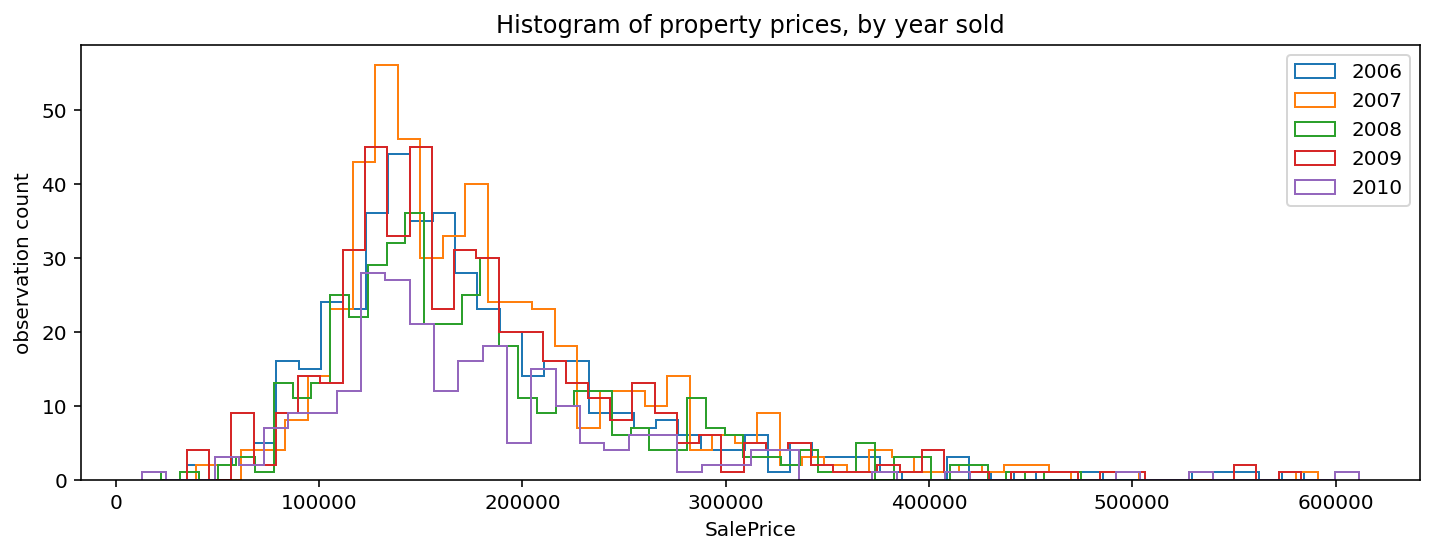

In [10]:
plt.figure(figsize=(12,4))
plt.title('Histogram of property prices, by year sold')
for yr in range(2006, 2011):
    plt.hist(train_data_orig[train_data_orig['Yr Sold']==yr]['SalePrice'], bins = 50, histtype = 'step', label = yr, )
    #plt.axvline(train_data_orig[train_data_orig['Yr Sold']==yr]['SalePrice'].mean(), ls ='--')
plt.xlabel('SalePrice')
plt.ylabel('observation count')
plt.legend();

**Seeing if `Misc Val` is associated with higher property value**

In [11]:
train_data[train_data['Misc Val']>0]['SalePrice'].agg(['mean', 'median'])

mean      160242.2
median    156500.0
Name: SalePrice, dtype: float64

_**Observation:**_ Both the mean and median are similar to the mean / median of the entire dataset - `Misc Val` doesn't seem to matter in a consistent way.

**Confirming consistency among values across all `Garage` variables**

In [12]:
garage_cols = [col for col in train_data_orig.columns if "Garage" in col]
train_data_orig[train_data_orig['Garage Type'].isna()][garage_cols].tail()
train_data_orig[(train_data_orig['Garage Type'].notna())&(train_data_orig['Garage Area'].isna())][garage_cols]

Garage Type  Garage Yr Blt Garage Finish  Garage Cars  Garage Area  \
1712      Detchd            NaN           NaN          NaN          NaN   

     Garage Qual Garage Cond  
1712         NaN         NaN

_**Observation:**_ There is only one observation where area is `nan` while Type is not `nan` - I will assume this 'Detchd' was entered in error and use area of 0.

**Confirming consistency between values across all `Basement` variables**

In [13]:
bsmt_cols = [col for col in train_data.columns if "Bsmt" in col]
train_data[train_data['Bsmt Qual'].isna()][bsmt_cols].head()

Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1  BsmtFin SF 1  \
12        NaN       NaN           NaN            NaN           0.0   
93        NaN       NaN           NaN            NaN           0.0   
114       NaN       NaN           NaN            NaN           0.0   
146       NaN       NaN           NaN            NaN           0.0   
183       NaN       NaN           NaN            NaN           0.0   

    BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Bsmt Full Bath  \
12             NaN           0.0          0.0            0.0             0.0   
93             NaN           0.0          0.0            0.0             0.0   
114            NaN           0.0          0.0            0.0             0.0   
146            NaN           0.0          0.0            0.0             0.0   
183            NaN           0.0          0.0            0.0             0.0   

     Bsmt Half Bath  
12              0.0  
93              0.0  
114             0.0  
146             0.0  
183             0.0

_**Observation:**_ all NaNs and zero's in columns descibing basements consistently point to absence of a garage.

**Exploring association between target variable and `Neighborhood`**

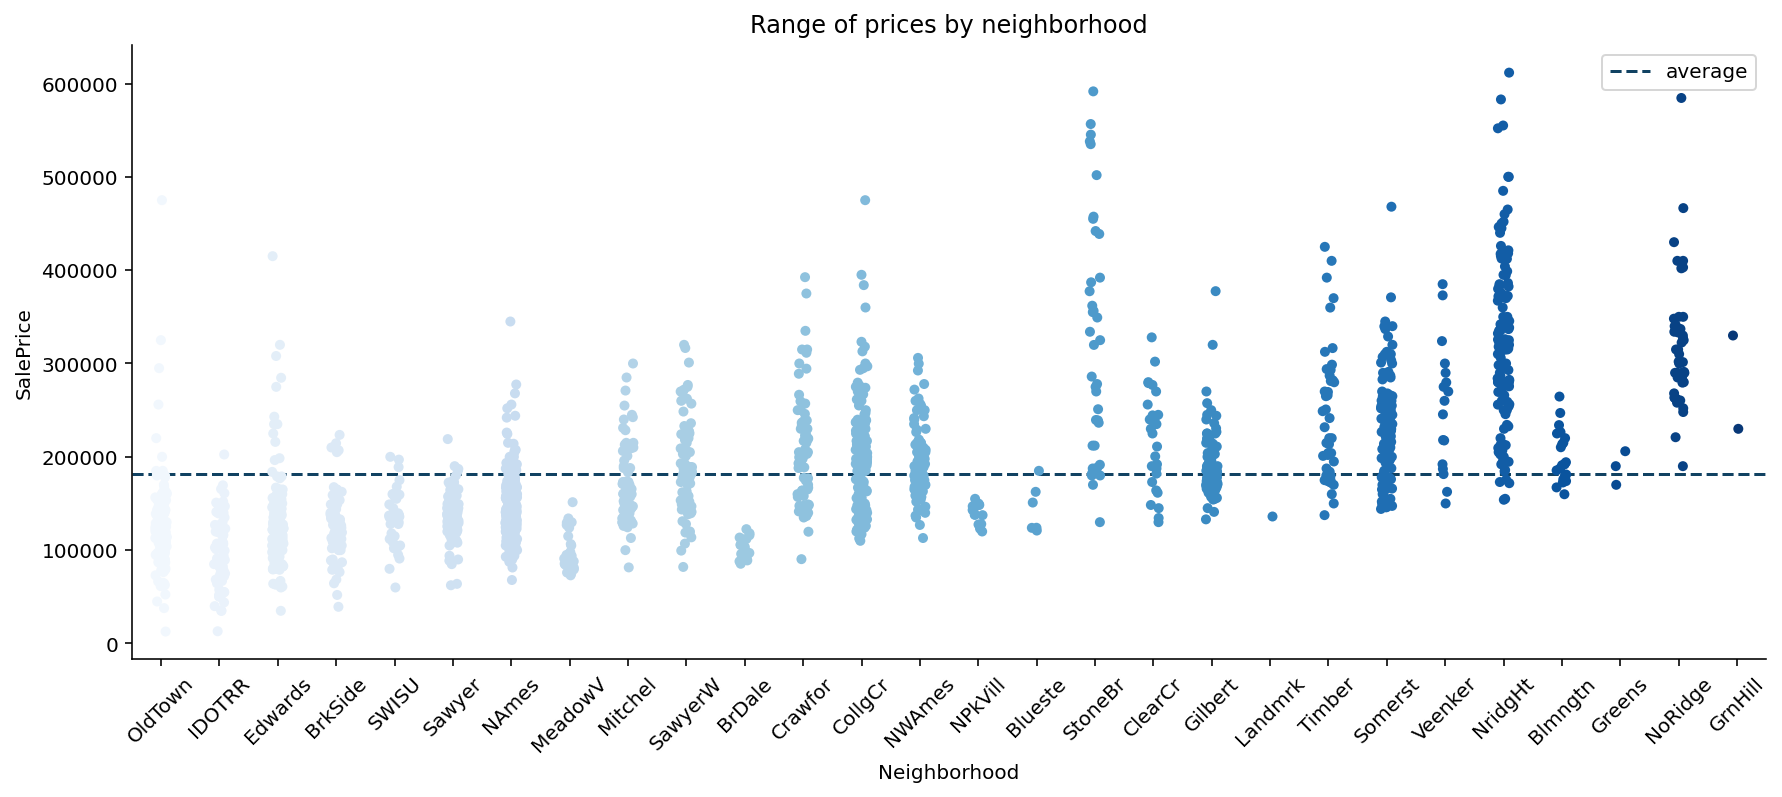

In [14]:
sns.catplot(data = train_data_orig.sort_values('SalePrice'), x = 'Neighborhood', y = 'SalePrice', aspect = 2.5, palette='Blues')
plt.title('Range of prices by neighborhood')
plt.axhline(train_data_orig['SalePrice'].mean(), color = '#114262ff', ls = '--', label='average')
plt.legend()
plt.xticks(rotation=45);

In [15]:
train_data_orig.groupby(['Neighborhood'])['SalePrice'].describe().sort_values('mean', ascending = False)[:7]

count           mean            std       min       25%  \
Neighborhood                                                            
StoneBr        38.0  329675.736842  128597.738212  130000.0  218125.0   
NridgHt       122.0  322831.352459   92964.835768  154000.0  259279.0   
NoRidge        48.0  316294.125000   67015.947652  190000.0  279875.0   
GrnHill         2.0  280000.000000   70710.678119  230000.0  255000.0   
Veenker        17.0  253570.588235   69147.647869  150000.0  192000.0   
Timber         48.0  241051.354167   70247.203305  137500.0  180375.0   
Somerst       130.0  227183.900000   55518.617822  144152.0  180500.0   

                   50%        75%       max  
Neighborhood                                 
StoneBr       322450.0  427085.00  591587.0  
NridgHt       317500.0  379040.50  611657.0  
NoRidge       300750.0  337750.00  584500.0  
GrnHill       280000.0  305000.00  330000.0  
Veenker       260000.0  290000.00  385000.0  
Timber        220000.0  281409.75  425000.0  
Somerst       224000.0  257375.00  468000.0

**_Observation:_** Seven of Ames' many neighborhoods are quite expensive.

**Visually evaluating linear relationships of other original characteristics with `SalePrice`**

In [16]:
orig_cols = train_data.columns[3:][:-2] # slicing to remove IDs, SalePrice, and calculated price per sqft
orig_cols_nn = orig_cols.drop('Neighborhood') # already looked at this one!

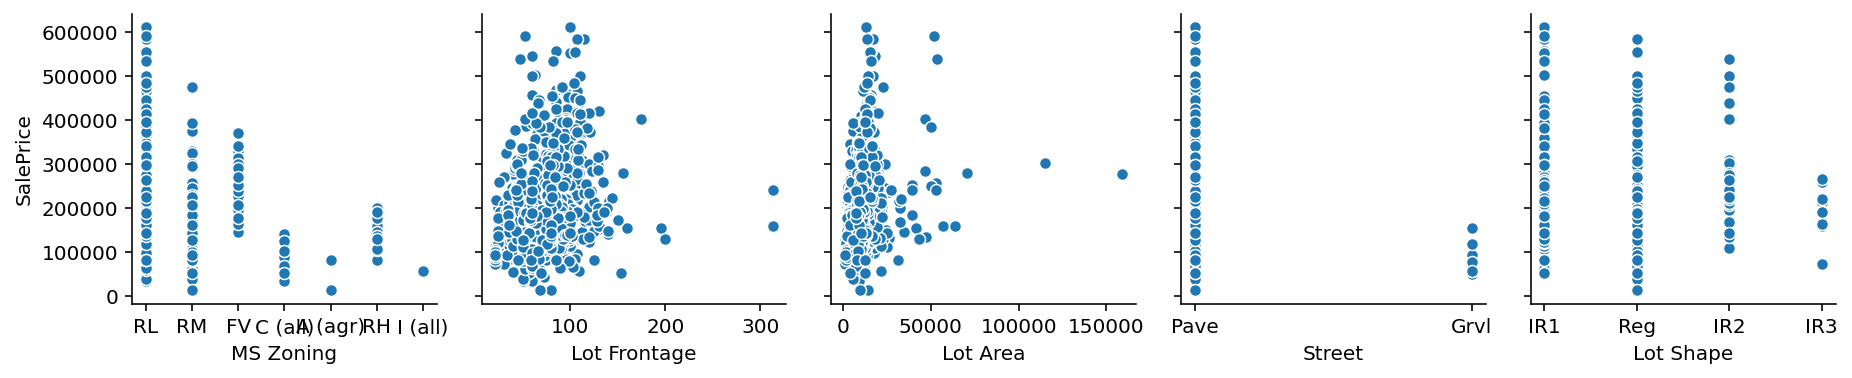

In [17]:
i = 0
sns.pairplot(data = train_data_orig, x_vars = orig_cols_nn[0+i:5+i], y_vars = ['SalePrice'])
i = i+5;

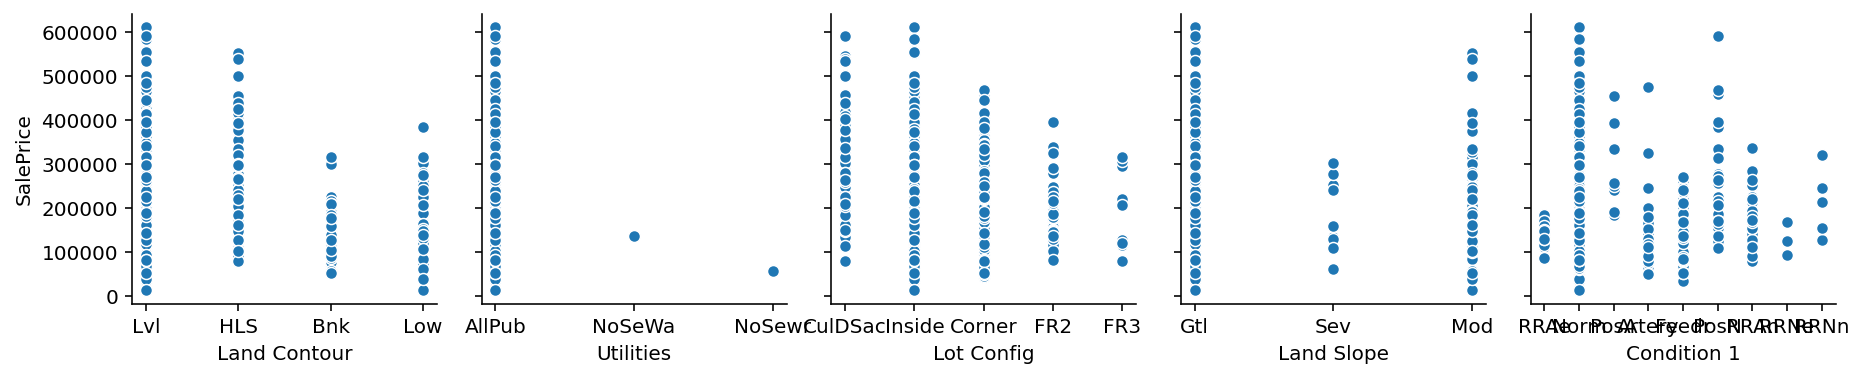

In [18]:
sns.pairplot(data = train_data_orig, x_vars = orig_cols_nn[0+i:5+i], y_vars = ['SalePrice'])
i = i+5;

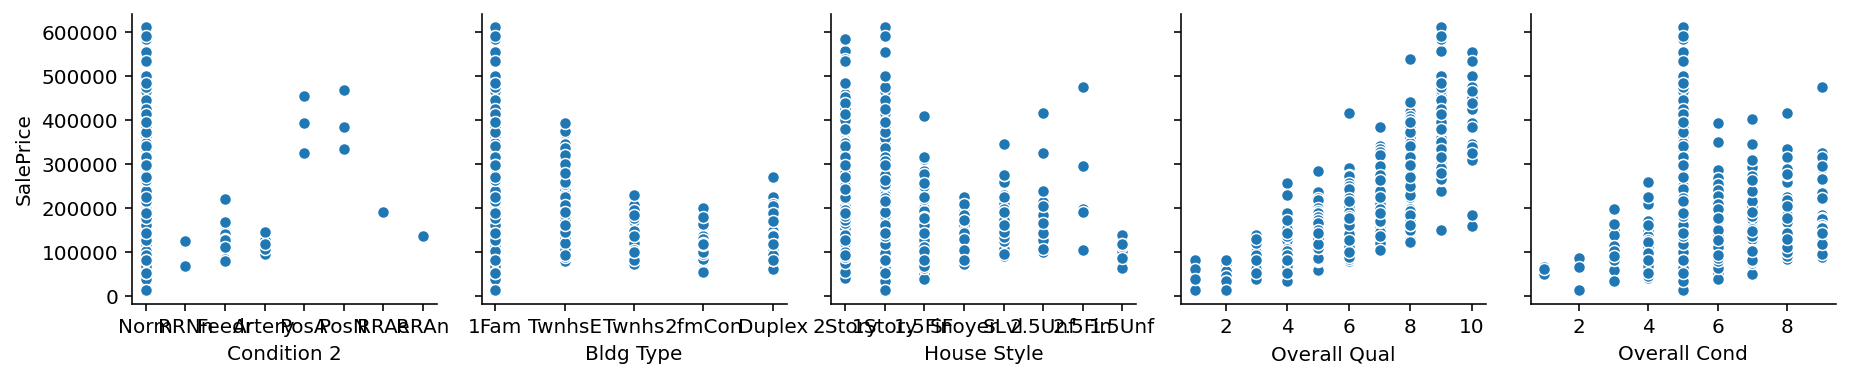

In [19]:
sns.pairplot(data = train_data_orig, x_vars = orig_cols_nn[0+i:5+i], y_vars = ['SalePrice'])
i = i+5;

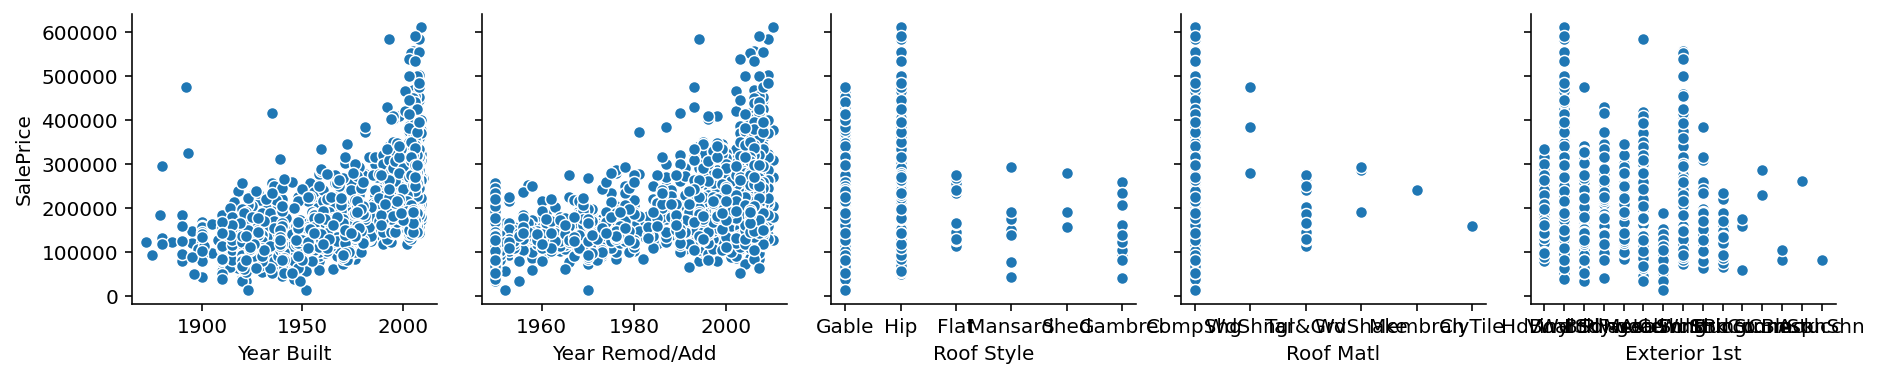

In [20]:
sns.pairplot(data = train_data_orig, x_vars = orig_cols_nn[0+i:5+i], y_vars = ['SalePrice'])
i = i+5;

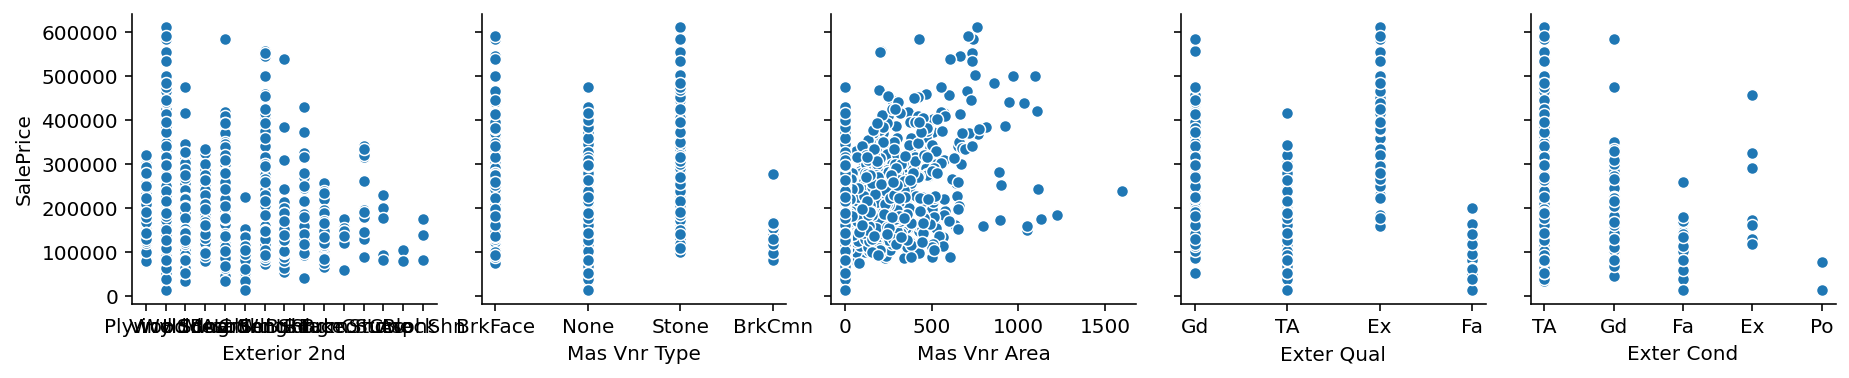

In [21]:
sns.pairplot(data = train_data_orig, x_vars = orig_cols_nn[0+i:5+i], y_vars = ['SalePrice'])
i = i+5;

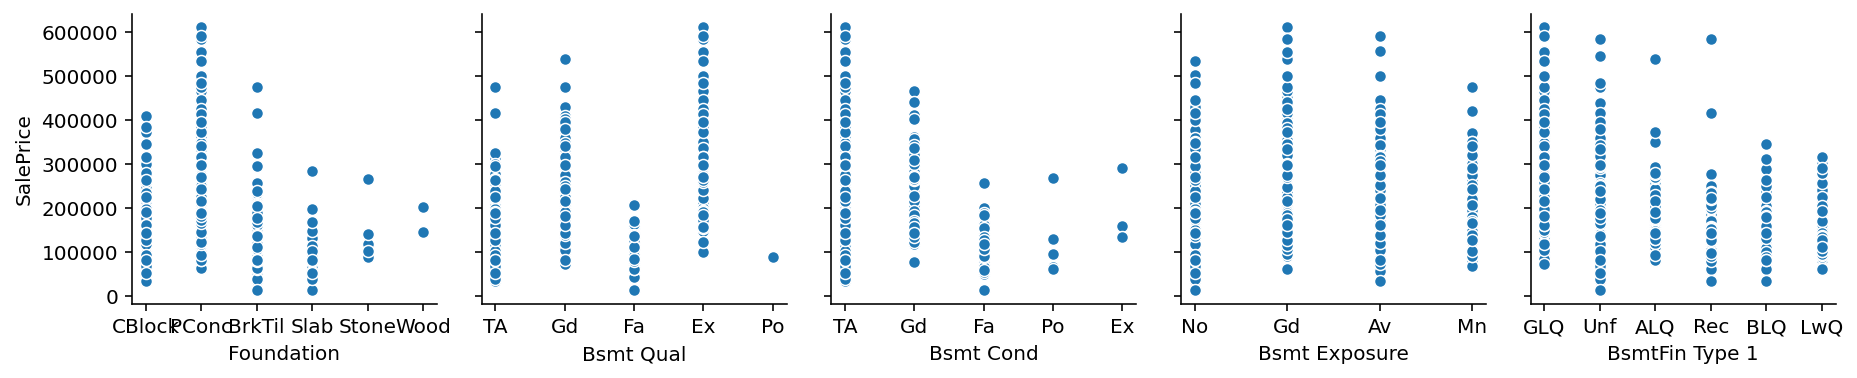

In [22]:
sns.pairplot(data = train_data_orig, x_vars = orig_cols_nn[0+i:5+i], y_vars = ['SalePrice'])
i = i+5;

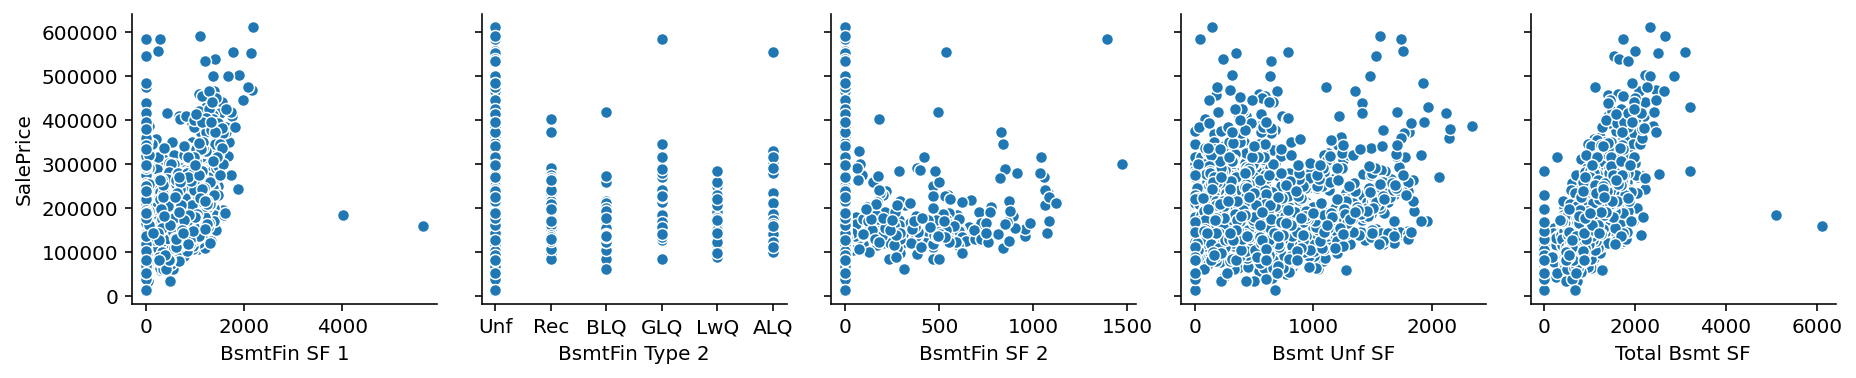

In [23]:
sns.pairplot(data = train_data_orig, x_vars = orig_cols_nn[0+i:5+i], y_vars = ['SalePrice'])
i = i+5;

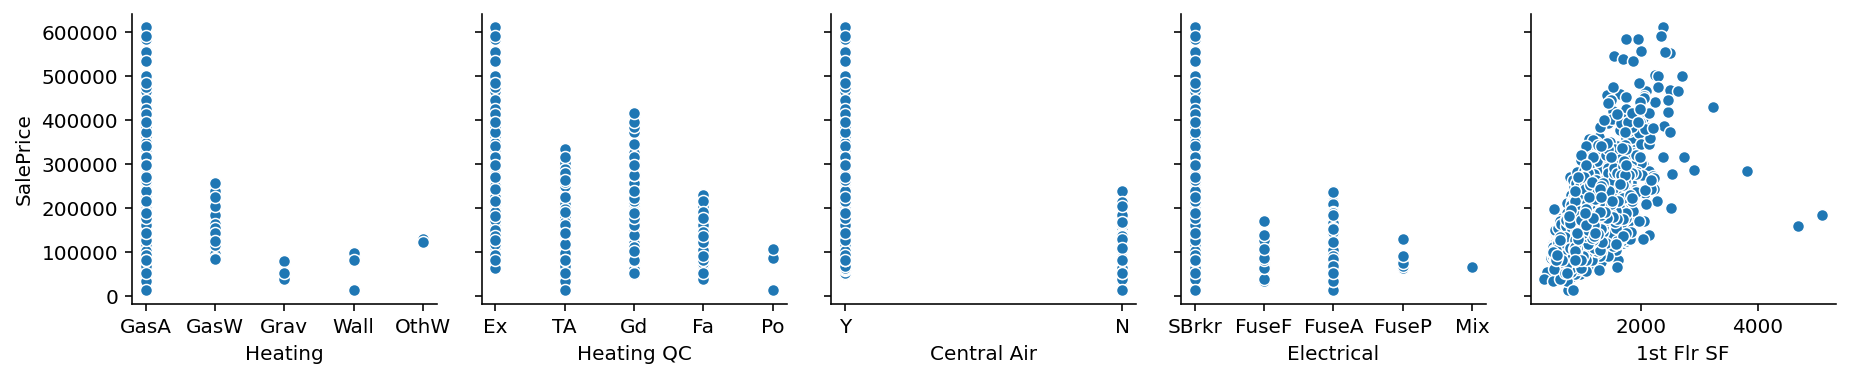

In [24]:
sns.pairplot(data = train_data_orig, x_vars = orig_cols_nn[0+i:5+i], y_vars = ['SalePrice'])
i = i+5;

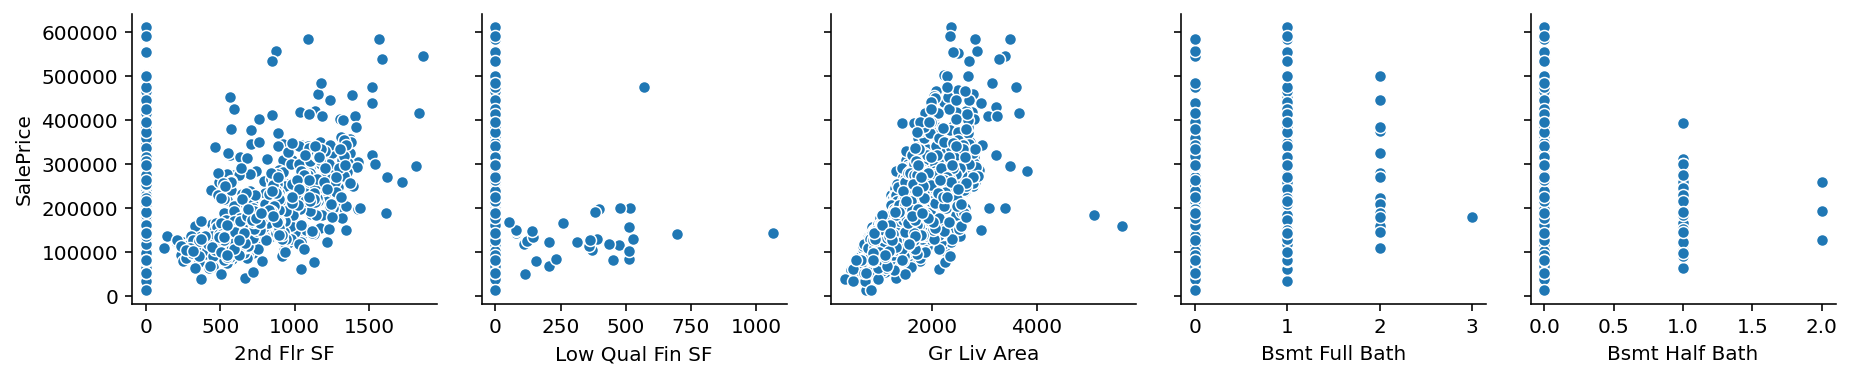

In [25]:
sns.pairplot(data = train_data_orig, x_vars = orig_cols_nn[0+i:5+i], y_vars = ['SalePrice'])
i = i+5;

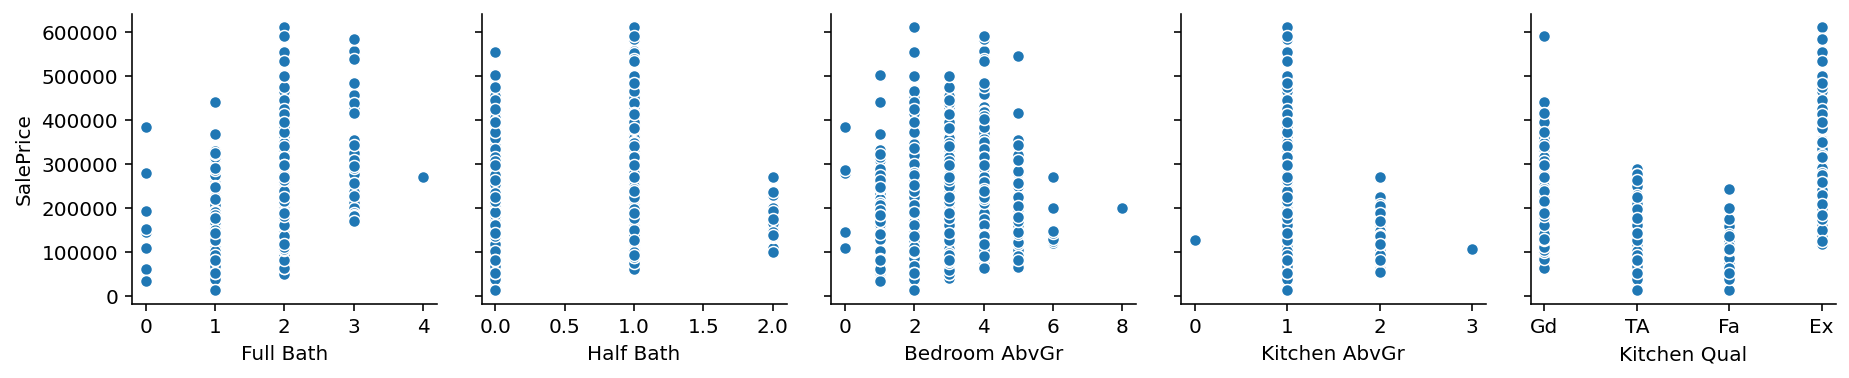

In [26]:
sns.pairplot(data = train_data_orig, x_vars = orig_cols_nn[0+i:5+i], y_vars = ['SalePrice'])
i = i+5;

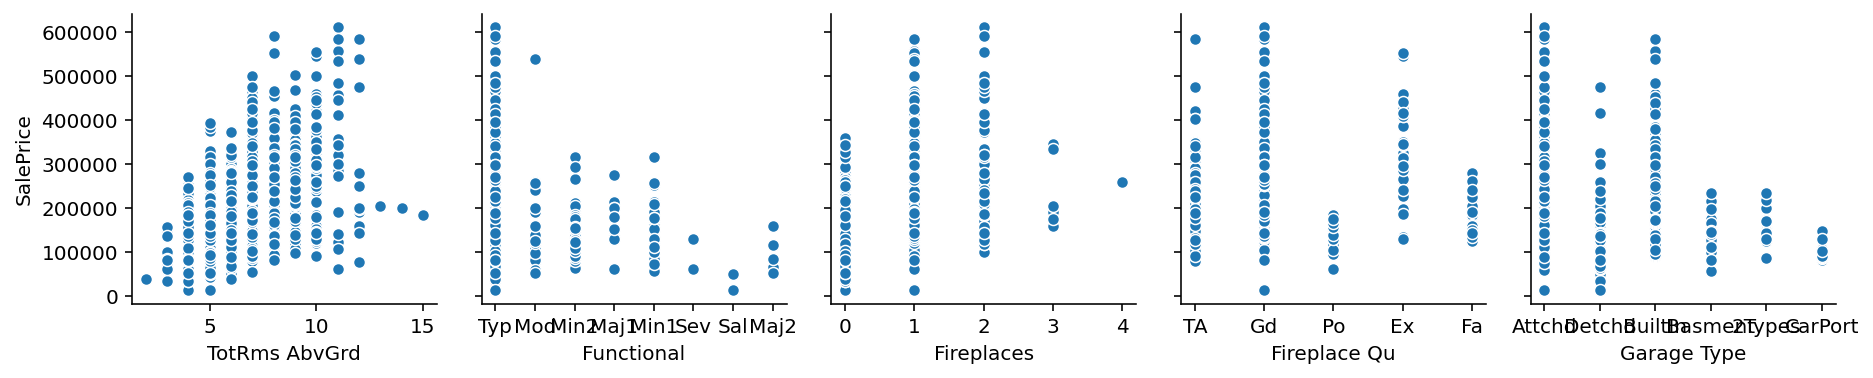

In [27]:
sns.pairplot(data = train_data_orig, x_vars = orig_cols_nn[0+i:5+i], y_vars = ['SalePrice'])
i = i+5;

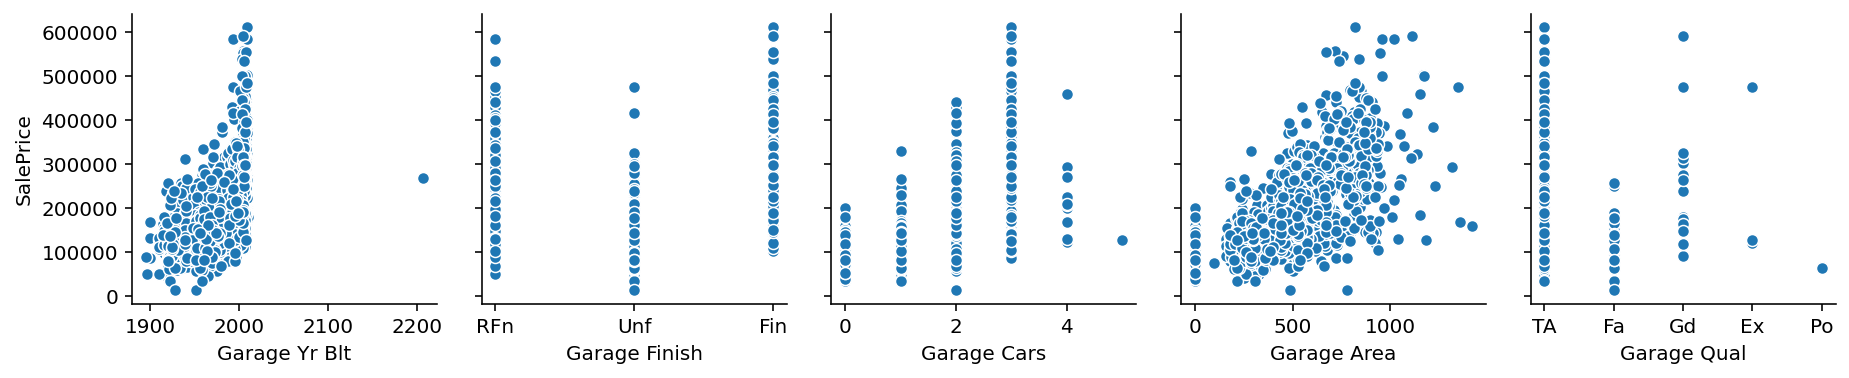

In [28]:
sns.pairplot(data = train_data_orig, x_vars = orig_cols_nn[0+i:5+i], y_vars = ['SalePrice'])
i = i+5;

In [29]:
train_data = train_data[train_data['Garage Yr Blt']!=2207] # outlier removed
#train_data.shape

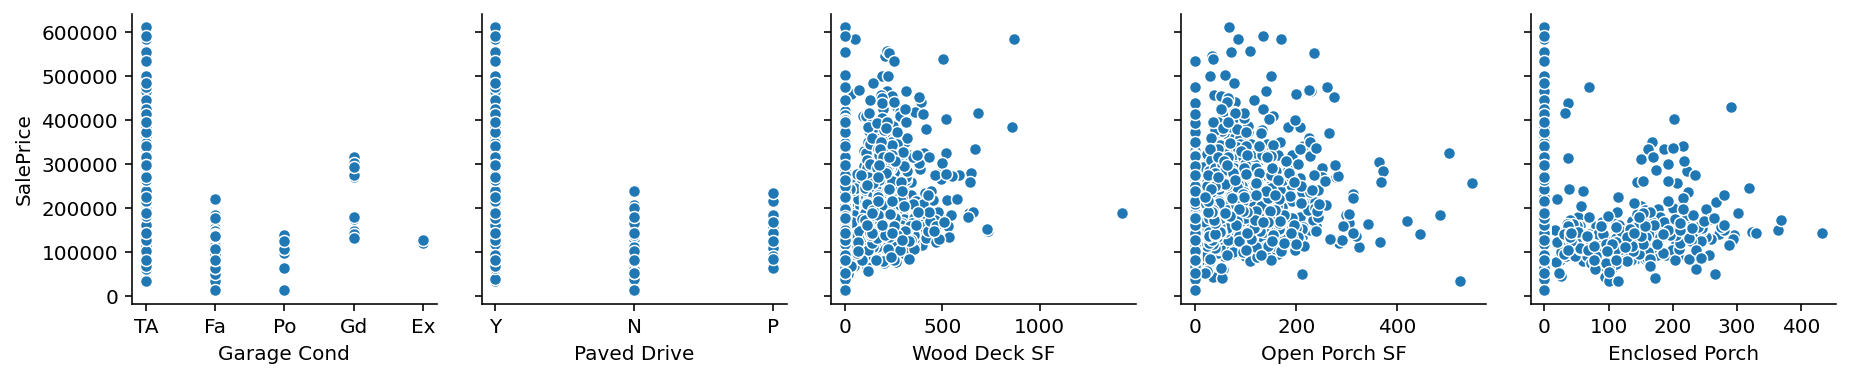

In [30]:
sns.pairplot(data = train_data_orig, x_vars = orig_cols_nn[0+i:5+i], y_vars = ['SalePrice'])
i = i+5;

In [31]:
train_data[train_data['Wood Deck SF']>1000][['Wood Deck SF', 'Gr Liv Area']]

Wood Deck SF  Gr Liv Area
966          1424         1356

In [32]:
train_data = train_data[train_data['Wood Deck SF']<1000] # it's not technically impossible that the deck is larger than the house but I am removing this house as an outlier nonetheless
#train_data.shape

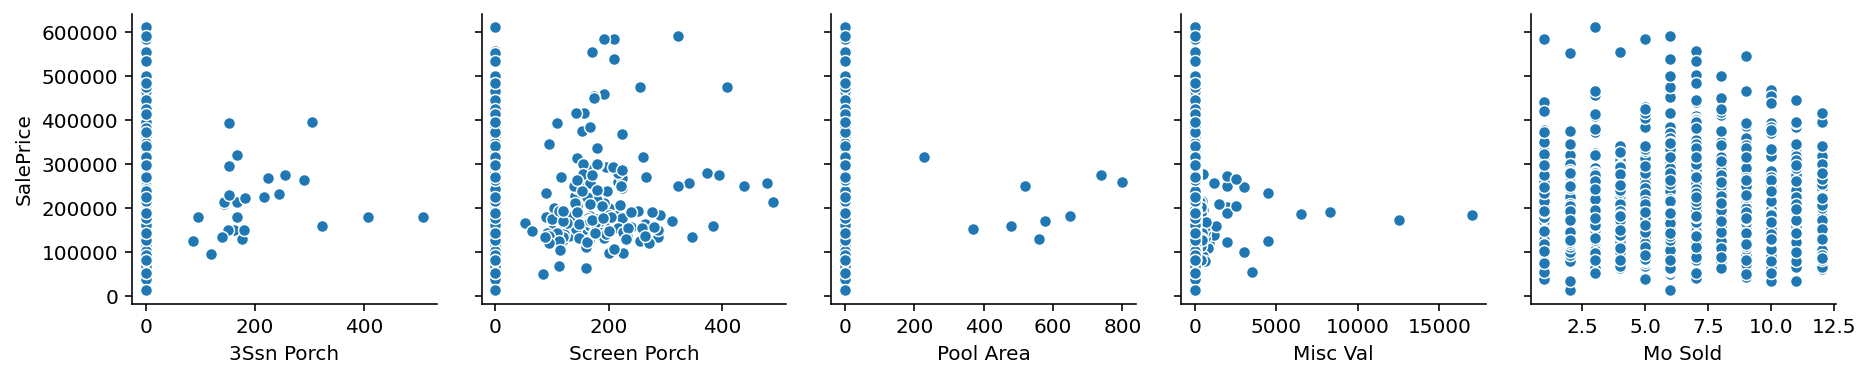

In [33]:
sns.pairplot(data = train_data_orig, x_vars = orig_cols_nn[0+i:5+i], y_vars = ['SalePrice'])
i = i+5;

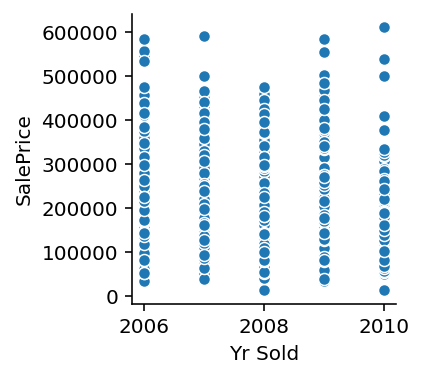

In [34]:
sns.pairplot(data = train_data_orig, x_vars = orig_cols_nn[0+i:5+i], y_vars = ['SalePrice'])
i = i+5;

**_Notes:_** While I did not take the time to make note of observations for each of the pairplots, they were very useful to me in identifiyng a couple outlier observations and in assessing which of the variables were most likely to drive `SalePrice`

**Filling missing values of `Lot Frontage`**

In [35]:
train_data[train_data['Lot Frontage'].isna()][['Lot Frontage', 'Lot Area']].head()

Lot Frontage  Lot Area
0            NaN     13517
7            NaN     12160
8            NaN     15783
23           NaN      7980
27           NaN     11700

Approximating `Lot Frontage` those observations where `Lot Area` is available as square root of area (while inaccurate, I trust this is better than mean or zero)

In [36]:
train_data['Lot Frontage'].fillna(train_data['Lot Area']**0.5, inplace = True)

In [37]:
train_data['Lot Frontage'].isna().sum() # checking to see if this addressed all of the NaNs

0

**Filling missing values of `Fireplace Qu`**

In [38]:
train_data[train_data['Fireplace Qu'].isna()][['Fireplace Qu', 'Fireplaces']].tail()

Fireplace Qu  Fireplaces
2034          NaN           0
2038          NaN           0
2039          NaN           0
2044          NaN           0
2047          NaN           0

Because NaNs correspond to houses with no fireplaces, it's safe to fill them with 0s (included with mapping ordinal values under Feature Engineering).

**Checking for multicollinearity within the original data**

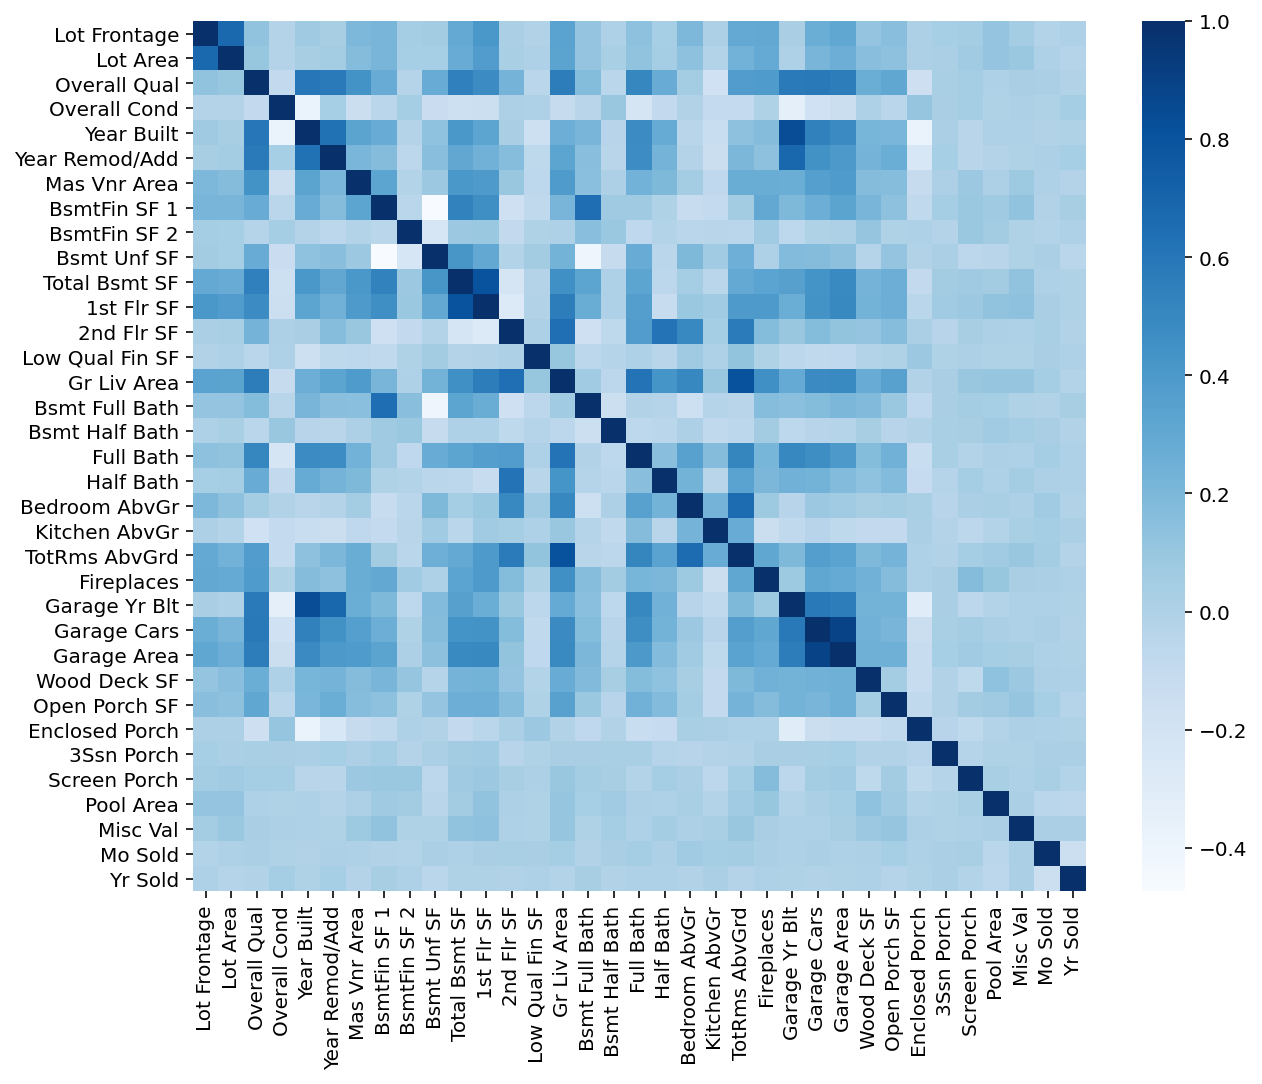

In [39]:
plt.figure(figsize = (10,8))
sns.heatmap(train_data[orig_cols].corr(), cmap = 'Blues');

**_Observations:_** It does not appear as though there is strong correlation between any two of the original descriptive characteristics.

## Part 3: Feature Engineering and Further Data Cleaning

**Creating a `Bathrooms` variable by adding `Full Bath` and 0.5*`Half Bath`**

In [40]:
train_data['Bathrooms'] = train_data['Full Bath'] + 0.5 * train_data['Half Bath']
#train_data[['Full Bath', 'Half Bath', 'Bathrooms']].head()

**Creating a binary `Pool` variable**

In [41]:
train_data['Pool'] = train_data['Pool Area'].apply(lambda x: 1 if x > 0 else 0)
#train_data[train_data['Pool Area']>0][['Pool', 'Pool Area']].head()

**Introducing a variable representing years since remodeling at the time of sale**

In [42]:
train_data['Year Sold'] = train_data['Yr Sold'] # copying "year sold" to avoid errors post-dummification

In [43]:
train_data['Yrs Since Constr or Remod'] = train_data['Yr Sold'] - train_data['Year Remod/Add']

In [44]:
train_data['Built after 2005'] = train_data['Year Sold'].apply(lambda x: 1 if x>=2005 else 0)

**Introducing an "inflation multiplier" - a variable representing the # of years before the earliest sale in data and each sale _(the LR coefficient will be a proxy for inflation)_**

In [45]:
train_data['Inflation Multiplier'] = train_data['Year Sold']-train_data['Year Sold'].min()

**Introducing a variable representing only square footage with high quality finish**

In [46]:
train_data['HQ SF'] = train_data['Gr Liv Area'] - train_data['Low Qual Fin SF']

**Constructing a variable representing proxity to positive location features (such as a park)**

In [47]:
train_data['Proximity to Pos Feat'] = train_data['Condition 1'].apply(lambda x: 1 if x == 'PosN' or x == 'PosA' else 0) + train_data['Condition 2'].apply(lambda x: 1 if x == 'PosN' or x == 'PosA' else 0)

**Mapping ordinal variables to their numerical representation**

In [48]:
# defining dictionaries for mapping of ordinal variables
five_scale_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 3, 'Po': 1}
six_scale_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}

# mapping all ordinal variables to their numeric values
train_data['Heating QC'] = train_data['Heating QC'].map(five_scale_map) #- doesn't seem to be very useful in the model
train_data['Kitchen Qual'] = train_data['Kitchen Qual'].map(five_scale_map)
train_data['Exter Qual'] = train_data['Exter Qual'].map(five_scale_map)
train_data['Exter Cond'] = train_data['Exter Cond'].map(five_scale_map)
train_data['Exter Qual x Cond'] = train_data['Exter Qual']*train_data['Exter Cond']

train_data['Garage Qual'] = train_data['Garage Qual'].map(six_scale_map)
train_data['Garage Cond'] = train_data['Garage Cond'].map(six_scale_map)
train_data['Garage Qual x Cond'] = train_data['Garage Qual']*train_data['Garage Cond']
train_data['Garage Qual x Cond'].fillna(0, inplace = True)
train_data['Garage Qual'].fillna(0, inplace = True)
train_data['Garage Cond'].fillna(0, inplace = True)

train_data['Bsmt Qual'] = train_data['Bsmt Qual'].map(six_scale_map)
train_data['Bsmt Cond'] = train_data['Bsmt Cond'].map(six_scale_map)
train_data['Bsmt Qual x Cond'] = train_data['Bsmt Qual']*train_data['Bsmt Cond']
train_data['Bsmt Qual x Cond'].fillna(0, inplace = True)
train_data['Bsmt Qual'].fillna(0, inplace = True)
train_data['Bsmt Cond'].fillna(0, inplace = True)

train_data['Fireplace Qu'] = train_data['Fireplace Qu'].map(five_scale_map)
train_data['Fireplace Qu'].fillna(0,inplace = True)

**Creating dummy variables representing non-numerical characteristics of interest**

In [49]:
train_data = pd.get_dummies(train_data, drop_first=False, columns = ['Bldg Type','Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Foundation', #'Bsmt Qual', #'Bsmt Cond',
'Central Air', 'Electrical', 'Functional','Paved Drive', 'MS SubClass', 'Yr Sold'])

**Grouping neighborhoods based on their general appeal as per average price per sqft _(after originally performing grouping based on average price, I realized by applying this method, I would correct for size, age, etc.)_**

In [50]:
train_data['USD_per_sqft'] = train_data['SalePrice']/train_data['Gr Liv Area']

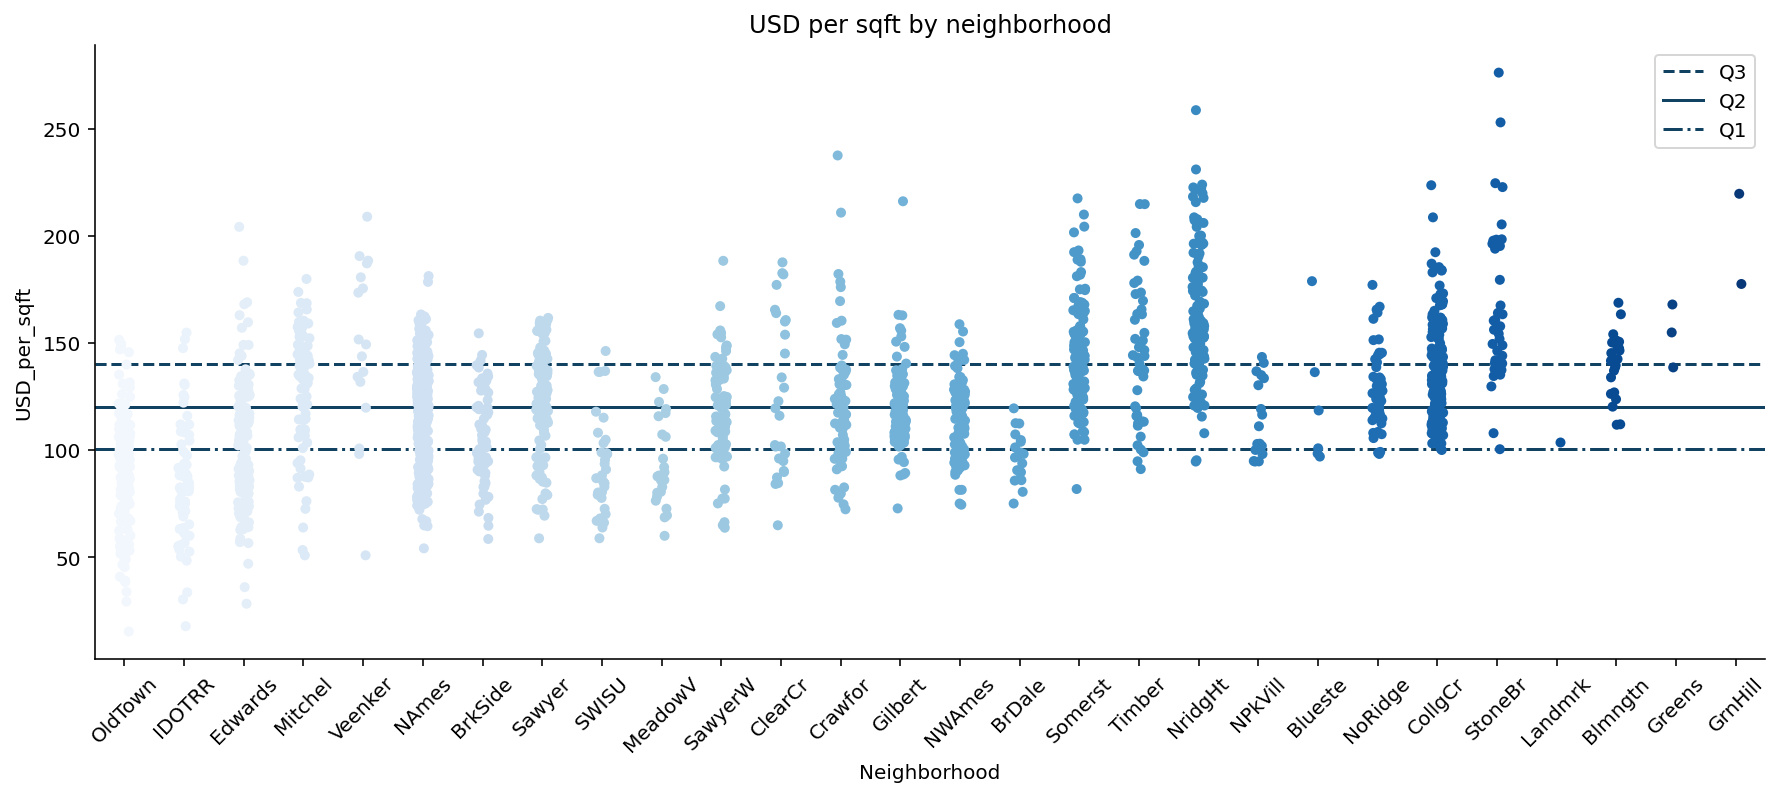

In [51]:
sns.catplot(data = train_data.sort_values('USD_per_sqft'), x = 'Neighborhood', y = 'USD_per_sqft', aspect = 2.5, palette='Blues')
plt.axhline(train_data['USD_per_sqft'].quantile(0.75), color = '#114262ff', ls = '--', label = 'Q3')
plt.axhline(train_data['USD_per_sqft'].quantile(0.5), color = '#114262ff', label = 'Q2')
plt.axhline(train_data['USD_per_sqft'].quantile(0.25), color = '#114262ff', ls = '-.', label = 'Q1')
plt.xticks(rotation=45)
plt.legend()
plt.title('USD per sqft by neighborhood');

Engineering a column (`Good Nhood`) to represent neighborhood based on average `USD_per_sqft` by applying the good_nhood function:

In [52]:
def good_nhood(neighborhood):
    if train_data[train_data['Neighborhood']==neighborhood]['USD_per_sqft'].mean() > train_data['USD_per_sqft'].quantile(0.75):
        return 3
    elif train_data[train_data['Neighborhood']==neighborhood]['USD_per_sqft'].mean() > train_data['USD_per_sqft'].quantile(0.5):
        return 2
    elif train_data[train_data['Neighborhood']==neighborhood]['USD_per_sqft'].mean() > train_data['USD_per_sqft'].quantile(0.25):
        return 1
    else:
        return 0

In [53]:
train_data['Good Nhood'] = train_data['Neighborhood'].apply(good_nhood)

**Zooming in on price per sqft to look for irregularities in data**

In [54]:
train_data['USD_per_sqft'].describe()

count    2049.000000
mean      121.653488
std        32.307969
min        15.371394
25%       100.524476
50%       120.412844
75%       140.453548
max       276.250881
Name: USD_per_sqft, dtype: float64

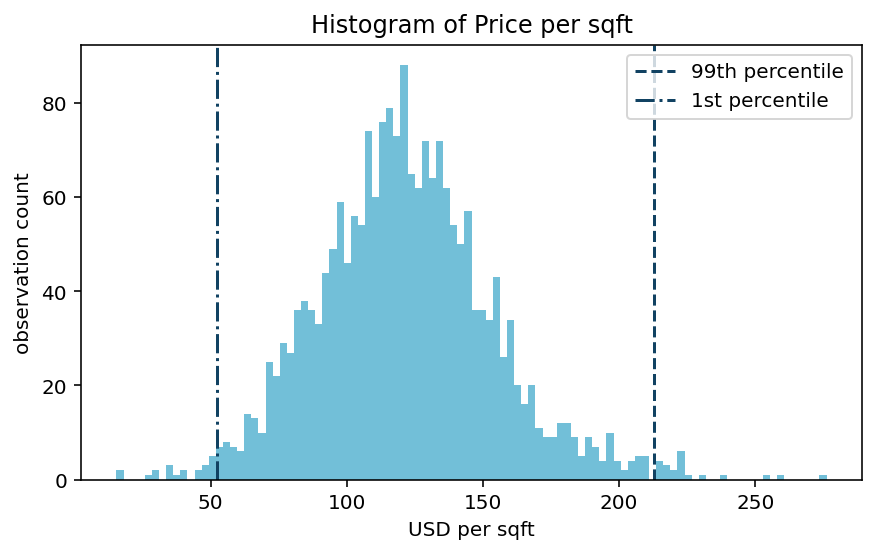

In [55]:
plt.figure(figsize = (7,4))
plt.hist(train_data_orig['USD_per_sqft'], bins = 100, color = '#1595bfff', alpha = 0.6)
plt.axvline(train_data_orig['USD_per_sqft'].quantile(0.99), ls = '--', color = '#114262ff', label = '99th percentile')
plt.axvline(train_data_orig['USD_per_sqft'].quantile(0.01), ls = '-.', color = '#114262ff', label = '1st percentile')
plt.xlabel('USD per sqft')
plt.ylabel('observation count')
plt.title('Histogram of Price per sqft')
plt.savefig('./visualizations/Histogram_USDperSQFT')
plt.legend();

_After taking a look to see if there was a clear reason for the extremely high / low prices per sqft, 21 observations in the top percentile and 21 observations in the bottom percentile were removed as outliers_

In [56]:
train_data = train_data[(train_data['USD_per_sqft']>train_data['USD_per_sqft'].quantile(0.01)) & (train_data['USD_per_sqft']<train_data['USD_per_sqft'].quantile(0.99))]

In [57]:
outliers_right = train_data_orig[train_data_orig['USD_per_sqft']>train_data_orig['USD_per_sqft'].quantile(0.99)]
outliers_left = train_data_orig[train_data_orig['USD_per_sqft']<train_data_orig['USD_per_sqft'].quantile(0.01)]

**Creating binary variables which indicate "prefferred" values of select features (those associated with higher prices, per EDA)**

In [58]:
train_data['Pref House Style'] = train_data['House Style'].apply(lambda x: 1 if x == '2Story' or x == '1Story' else 0)
train_data['Pref Garage Type'] = train_data['Garage Type'].apply(lambda x: 1 if x == 'Attchd' or x == 'BuiltIn' else 0)
train_data['Sold as New'] = train_data['Sale Type'].apply(lambda x: 1 if x == 'New' else 0)
train_data['Gtl Land Slope'] = train_data['Land Slope'].apply(lambda x: 1 if x == 'Gtl' else 0)
train_data['Pref Lot Config'] = train_data['Lot Config'].apply(lambda x: 1 if x == 'CulDSac' or x == 'Inside' else 0)
train_data['Zone RL'] = train_data['MS Zoning'].apply(lambda x: 1 if x == 'RL' else 0)
train_data['Pref Mas Vnr'] = train_data['Mas Vnr Type'].apply(lambda x: 1 if x == 'BrkFace' or x == 'Stone' else 0)

**Filling NaNs for select columns**

In [59]:
train_data['Mas Vnr Area'].fillna(train_data['Mas Vnr Area'].mean(), inplace= True) #to not remove 20 observations because of a variable which I might not use, I filled absent values with mean
train_data['Total Bsmt SF'].fillna(0, inplace = True) # NaNs correspond to houses with no basement info (see EDA section)
train_data['Garage Cars'].fillna(0, inplace=True) # NaNs correspond to houses with no garage (see EDA section)
train_data['Garage Area'].fillna(0, inplace=True) # NaNs correspond to houses with no garage (see EDA section)
train_data['BsmtFin SF 1'].fillna(0, inplace = True) # only one observation affected

**Saving cleaned train data to a csv file**

In [60]:
train_data.to_csv('./clean_data/train_data_cleaned.csv')

## Part 4: Modeling

### 4.1: Baseline Model

**A baseline model using only one independent variable: `Gr Liv Area`**

In [61]:
# creating independent variable (X) array and dependent variable y:
X_base = train_data[['Gr Liv Area']]
y_base = train_data['SalePrice']

# splitting data into a training set and test set:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base)

# instantiating, fitting, and scoring the baseline model:
lr_base = LinearRegression()
lr_base.fit(X_train_base,y_train_base)

LinearRegression()

In [62]:
print(f" The simple baseline model achieves an R2 of {lr_base.score(X_train_base,y_train_base).round(4)} on test data and an R2 of {lr_base.score(X_test_base, y_test_base).round(4)} on test data.")
print(f" The cross-validation score of the baseline model is {cross_val_score(lr_base, X_base, y_base).mean().round(4)}.")

 The simple baseline model achieves an R2 of 0.5436 on test data and an R2 of 0.5936 on test data.
 The cross-validation score of the baseline model is 0.5557.


**Visualization of results**

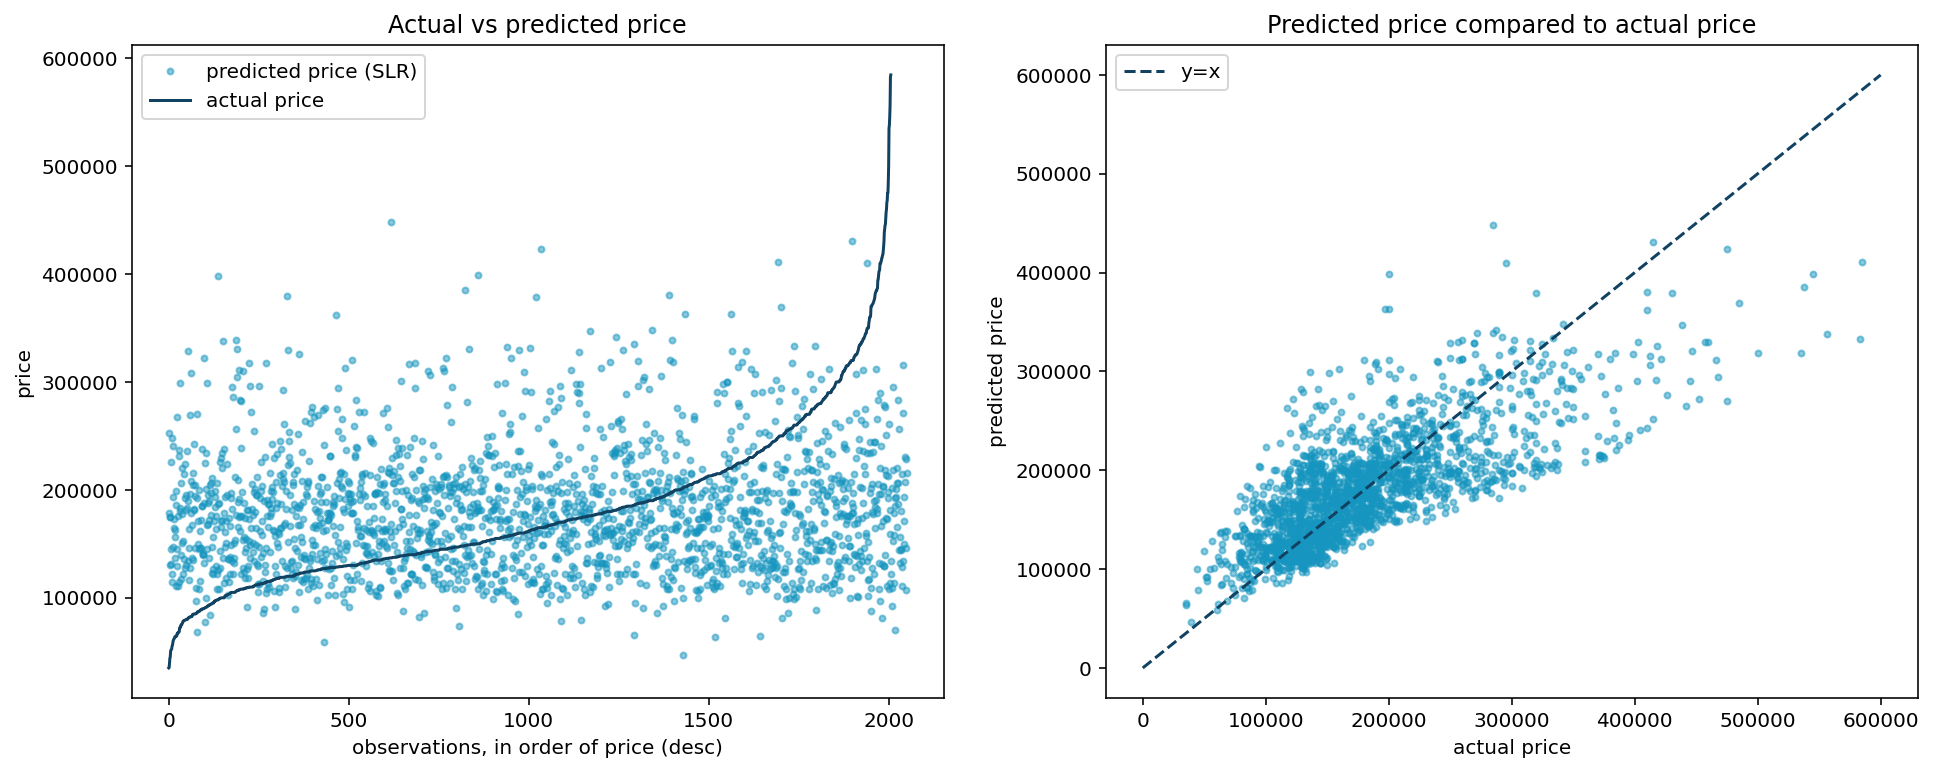

In [63]:
base_pred = pd.DataFrame(y_base.T)
base_pred['PredPrice'] = lr_base.predict(X_base)
base_pred['Gr Liv Area'] = X_base['Gr Liv Area']
base_pred = base_pred.sort_values('SalePrice')

plt.figure(figsize = (16,6))
plt.subplot(1,2,2)
plt.scatter(base_pred['SalePrice'], base_pred['PredPrice'], color = '#1595bf', marker = ".", alpha = 0.5)
plt.plot([0,600000], [0,600000], color = '#114262ff', ls = '--', label = 'y=x')
plt.xlabel('actual price')
plt.ylabel('predicted price')
plt.title('Predicted price compared to actual price')
plt.legend()
#plt.ylim(0,600000)

plt.subplot(1,2,1)
plt.plot(base_pred.index, base_pred['PredPrice'], color = '#1595bf', ls = '', marker = ".", alpha = 0.5, label = 'predicted price (SLR)')
plt.plot(range(0, len(base_pred)), base_pred['SalePrice'], color = '#114262ff', label = 'actual price')
plt.xlabel('observations, in order of price (desc)')
plt.ylabel('price')
plt.title('Actual vs predicted price')
plt.legend()
#plt.ylim(0,600000)

plt.savefig('./visualizations/base_model.png')

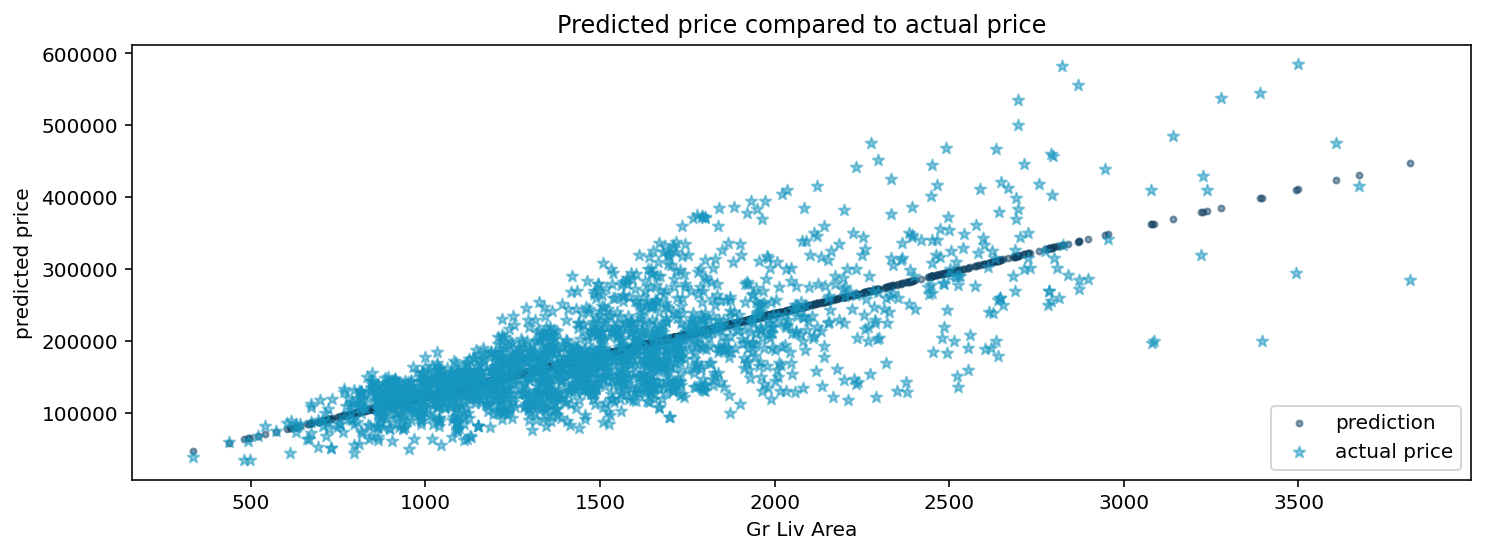

In [64]:
base_pred = base_pred.sort_values('Gr Liv Area')

plt.figure(figsize = (12,4))

plt.scatter(base_pred['Gr Liv Area'], base_pred['PredPrice'], color = '#114262ff', marker = ".", alpha = 0.5, label = 'prediction')
plt.scatter(base_pred['Gr Liv Area'], base_pred['SalePrice'], color = '#1595bf', marker = "*", alpha = 0.5, label = 'actual price')
plt.xlabel('Gr Liv Area')
plt.ylabel('predicted price')
plt.title('Predicted price compared to actual price')
plt.legend(loc = 'lower right');

### 4.2: Model Iterations

#### 4.2.1: Model Iteration #1

**Looking to enhance the model by adding some of the X variables which were available in original data or engineered in Part 3**

In [65]:
X_1 = ['Gr Liv Area', 'Bedroom AbvGr', 'Bathrooms', 'Pool', 'Yrs Since Constr or Remod']

X_one = train_data[X_1]
y = train_data['SalePrice']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_one, y)

mlr_1 = LinearRegression()
mlr_1.fit(X_train_1, y_train_1)

print(f"R2 on training data = {mlr_1.score(X_train_1, y_train_1).round(4)}")
print(f"R2 on test data = {mlr_1.score(X_test_1, y_test_1).round(4)}")
print(f"Average R2 in 5-fold cross-validation = {cross_val_score(mlr_1, X_one, y).mean().round(4)} (std of {cross_val_score(mlr_1, X_one, y).std().round(4)})")

R2 on training data = 0.6875
R2 on test data = 0.7244
Average R2 in 5-fold cross-validation = 0.6945 (std of 0.0206)


**Visualization of results**

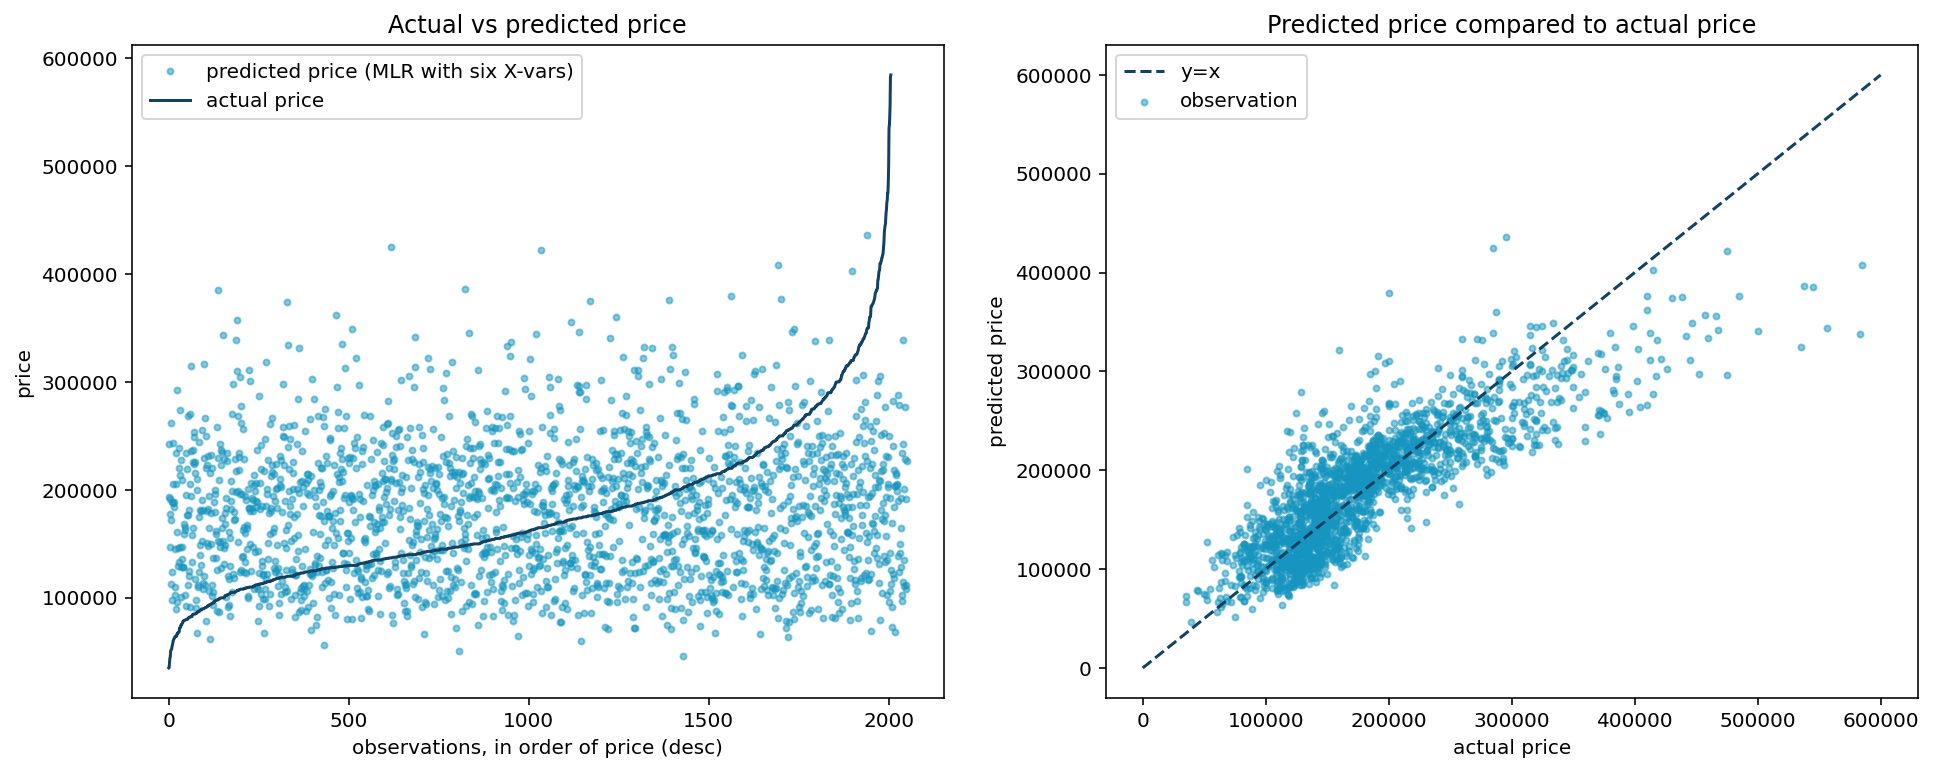

In [66]:
mlr1_pred = pd.DataFrame(y.T)
mlr1_pred['PredPrice'] = mlr_1.predict(X_one)
mlr1_pred = mlr1_pred.sort_values('SalePrice')

plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(mlr1_pred.index, mlr1_pred['PredPrice'], color = '#1595bf', ls = '', marker = ".", alpha = 0.5, label = 'predicted price (MLR with six X-vars)')
plt.plot(range(0, len(mlr1_pred)), mlr1_pred['SalePrice'], color = '#114262ff', label = 'actual price')
#plt.scatter(mlr1_pred['Gr Liv Area'], mlr1_pred['SalePrice'], color = '#1595bfff', marker = ".", alpha = 0.5)
plt.xlabel('observations, in order of price (desc)')
plt.ylabel('price')
plt.title('Actual vs predicted price')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(mlr1_pred['SalePrice'], mlr1_pred['PredPrice'], color = '#1595bf', marker = ".", alpha = 0.5, label = 'observation')
plt.plot([0,600000], [0,600000], color = '#114262ff', ls = '--', label = 'y=x')
plt.xlabel('actual price')
plt.ylabel('predicted price')
plt.title('Predicted price compared to actual price')
plt.legend()

plt.savefig('./visualizations/mlr1');

#### 4.2.2: Model Iteration #2

**Scaling independent variables**

In [67]:
X_3 = ['Gr Liv Area', 'Bedroom AbvGr', 'Bathrooms', 'Pool', 'Yrs Since Constr or Remod']

X_three = train_data[X_3]
y = train_data['SalePrice']

scaler = StandardScaler()
X_three_sc = scaler.fit_transform(X_three)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_three, y)

mlr_3 = LinearRegression()
mlr_3.fit(X_train_3, y_train_3)

print(f"R2 on training data = {mlr_3.score(X_train_3, y_train_3).round(4)}")
print(f"R2 on test data = {mlr_3.score(X_test_3, y_test_3).round(4)}")
print(f"Average R2 in 5-fold cross-validation = {cross_val_score(mlr_3, X_three, y).mean().round(4)} (std of {cross_val_score(mlr_3, X_three, y).std().round(4)})")

R2 on training data = 0.6969
R2 on test data = 0.6946
Average R2 in 5-fold cross-validation = 0.6945 (std of 0.0206)


_**Notes:**_ In this case, scaling variables does not improve the model, but in remaining iterations I consistently scaled all non-binary independent variables.

#### 4.2.3: Model Iteration #3

Adding more independent variables, scaling all non-binary X variables

In [68]:
X_2 = ['HQ SF', 'Low Qual Fin SF', 'Bedroom AbvGr', 'Bathrooms', 'Pool', 'Yrs Since Constr or Remod', 'Kitchen Qual', 'Exter Qual', 'Exter Cond', 
       'Bldg Type_1Fam', 'Garage Cars', 'Functional_Typ', 'Overall Qual', 'Overall Cond', 'Inflation Multiplier', 'Good Nhood', 
       'Lot Area', 'Foundation_PConc', 'Garage Qual', 'Garage Cond', 'Bsmt Qual', 'Bsmt Cond', 
        'Pref Garage Type', 'Sold as New', 'Paved Drive_Y', 'Gtl Land Slope', 'Exterior 1st_VinylSd', 'Exterior 1st_CemntBd', 
       'Mas Vnr Area', 'Lot Frontage','Zone RL', 'Fireplaces', 'Fireplace Qu','Pref Lot Config', 'Roof Style_Hip', 
       'Electrical_SBrkr', 'Central Air_Y', '1st Flr SF', '2nd Flr SF', 'Garage Area', 'Yr Sold_2007', 
       'Yr Sold_2008', 'Yr Sold_2009', 'Yr Sold_2010', 'Year Sold', 'MS SubClass_30', 'MS SubClass_40',
       'MS SubClass_45', 'MS SubClass_50', 'MS SubClass_60', 'MS SubClass_70', 'MS SubClass_75', 'MS SubClass_80',
       'MS SubClass_85', 'MS SubClass_90', 'MS SubClass_120', 'MS SubClass_150', 'MS SubClass_160', 'MS SubClass_180',
        'MS SubClass_190', 'Total Bsmt SF']

X_two = train_data[X_2]

X_2_bin = [col for col in X_2 if X_two[col].dtype == 'uint8'] # binary vars
X_2_other = [col for col in X_2 if X_two[col].dtype != 'uint8'] #non-binary vars

X_two_bin = train_data[X_2_bin]
X_two_other = train_data[X_2_other]
y = train_data['SalePrice']

scaler = StandardScaler()
X_two_other_sc = scaler.fit_transform(X_two_other)
X_two_other_sc_df = pd.DataFrame(data = X_two_other_sc, columns = X_2_other)
X_two = pd.concat([X_two_other_sc_df,X_two_bin.reset_index(drop=True)], axis = 1)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_two, y)

mlr_2 = LinearRegression()
mlr_2.fit(X_train_2, y_train_2)

print(f"R2 on training data = {mlr_2.score(X_train_2, y_train_2).round(4)}")
print(f"R2 on test data = {mlr_2.score(X_test_2, y_test_2).round(4)}")

print(f"Average R2 in 5-fold cross-validation = {cross_val_score(mlr_2, X_two, y).mean().round(4)} (std of {cross_val_score(mlr_2, X_two, y).std().round(4)})")

R2 on training data = 0.894
R2 on test data = 0.9039
Average R2 in 5-fold cross-validation = 0.8865 (std of 0.0052)


**Visualization of results**

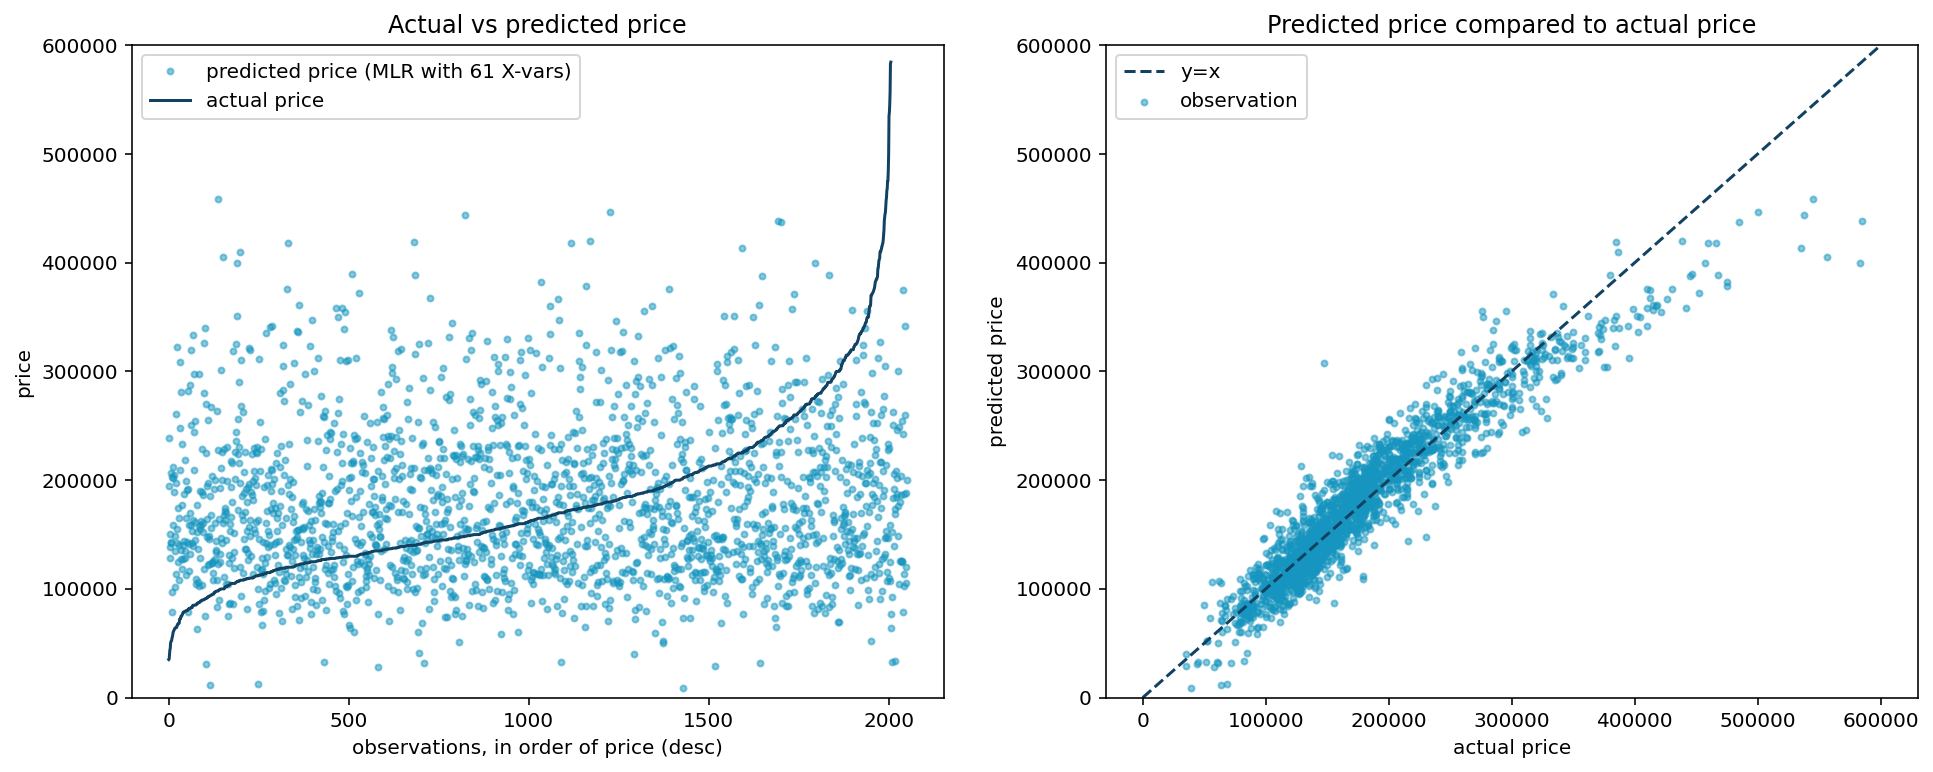

In [69]:
mlr2_pred = pd.DataFrame(y.T)
mlr2_pred['PredPrice'] = mlr_2.predict(X_two)
mlr2_pred = mlr2_pred.sort_values('SalePrice')

plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(mlr2_pred.index, mlr2_pred['PredPrice'], color = '#1595bf', ls = '', marker = ".", alpha = 0.5, label = 'predicted price (MLR with 61 X-vars)')
plt.plot(range(0, len(mlr2_pred)), mlr2_pred['SalePrice'], color = '#114262ff', label = 'actual price')
#plt.scatter(mlr1_pred['Gr Liv Area'], mlr1_pred['SalePrice'], color = '#1595bfff', marker = ".", alpha = 0.5)
plt.xlabel('observations, in order of price (desc)')
plt.ylabel('price')
plt.title('Actual vs predicted price')
plt.legend()
plt.ylim(0,600000)

plt.subplot(1,2,2)
plt.scatter(mlr2_pred['SalePrice'], mlr2_pred['PredPrice'], color = '#1595bf', marker = ".", alpha = 0.5, label = 'observation')
plt.plot([0,600000], [0,600000], color = '#114262ff', ls = '--', label = 'y=x')
plt.xlabel('actual price')
plt.ylabel('predicted price')
plt.title('Predicted price compared to actual price')
plt.legend()
plt.ylim(0,600000)

plt.savefig('./visualizations/mlr2');

#### 4.4 Model Iteration #4

Iteratively removing dependent variables variables with p-values > 0.05 _(while this was described as p-hacking, and I understand this is not the intended use of p-values, I still found it a valuable exercise and lesson!)_

In [70]:
X_5 = ['HQ SF', 'Low Qual Fin SF', 'Bedroom AbvGr', 'Kitchen Qual',
       'Garage Cars', 'Functional_Typ', 'Overall Qual', 'Good Nhood', 
       'Lot Area', 'Garage Cond', 'Bsmt Cond','Sold as New', 'Gtl Land Slope', 'Exterior 1st_CemntBd', 
       'Mas Vnr Area', 'Fireplaces', 'Roof Style_Hip', 
        '1st Flr SF', '2nd Flr SF', 'Garage Area', 'Yr Sold_2007', 'MS SubClass_70', 
       'MS SubClass_90', 'MS SubClass_120', 'MS SubClass_160', 'Yrs Since Constr or Remod', 'Total Bsmt SF', 'Wood Deck SF',
      'BsmtFin SF 1']

X_five = train_data[X_5]

X_5_bin = [col for col in X_5 if X_five[col].dtype == 'uint8'] # binary vars
X_5_other = [col for col in X_5 if X_five[col].dtype != 'uint8'] #non-binary vars

X_five_bin = train_data[X_5_bin]
X_five_other = train_data[X_5_other]
y = train_data['SalePrice']

scaler = StandardScaler()
X_five_other_sc = scaler.fit_transform(X_five_other)
X_five_other_sc_df = pd.DataFrame(data = X_five_other_sc, columns = X_5_other)
X_five = pd.concat([X_five_other_sc_df,X_five_bin.reset_index(drop=True)], axis = 1)

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_five, y)

mlr_5 = LinearRegression()
mlr_5.fit(X_train_5, y_train_5)

print(f"R2 on training data = {mlr_5.score(X_train_5, y_train_5).round(4)}")
print(f"R2 on test data = {mlr_5.score(X_test_5, y_test_5).round(4)}")

print(f"Average R2 in 5-fold cross-validation = {cross_val_score(mlr_5, X_five, y).mean().round(4)} (std of {cross_val_score(mlr_5, X_five, y).std().round(4)})")

R2 on training data = 0.9019
R2 on test data = 0.8928
Average R2 in 5-fold cross-validation = 0.8936 (std of 0.0067)


Obtaining p-vals from OLS report _(iterative process, below is the summary of results)_

In [71]:
X_five_ = train_data.reset_index()[X_5]
sm.add_constant(X_five_)
y_ = train_data.reset_index()['SalePrice']

model = sm.OLS(y_,X_five_).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              4618.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        20:35:20   Log-Likelihood:                         -23080.
No. Observations:                2007   AIC:                                  4.622e+04
Df Residuals:                    1979   BIC:                                  4.637e+04
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
HQ SF                        39.0271      1.499     26.028      0.000      36.086      41.968
Low Qual Fin SF              27.6892     10.822      2.559      0.011       6.466      48.913
Bedroom AbvGr             -7657.2831    907.211     -8.440      0.000   -9436.471   -5878.095
Kitchen Qual               7654.4388   1138.752      6.722      0.000    5421.161    9887.717
Garage Cars                3733.9336   1738.336      2.148      0.032     324.772    7143.095
Functional_Typ             1.106e+04   2335.033      4.739      0.000    6485.531    1.56e+04
Overall Qual               1.077e+04    715.277     15.062      0.000    9370.797    1.22e+04
Good Nhood                 9299.0731    789.557     11.778      0.000    7750.623    1.08e+04
Lot Area                      0.3608      0.096      3.764      0.000       0.173       0.549
Garage Cond               -5461.1717    971.677     -5.620      0.000   -7366.788   -3555.555
Bsmt Cond                 -7451.4802   1106.709     -6.733      0.000   -9621.917   -5281.044
Sold as New                1.656e+04   2338.240      7.081      0.000     1.2e+04    2.11e+04
Gtl Land Slope            -1.549e+04   2532.669     -6.117      0.000   -2.05e+04   -1.05e+04
Exterior 1st_CemntBd       1.505e+04   2815.126      5.346      0.000    9528.912    2.06e+04
Mas Vnr Area                 36.6019      3.819      9.584      0.000      29.112      44.092
Fireplaces                 4362.7359   1044.723      4.176      0.000    2313.863    6411.609
Roof Style_Hip             7125.3643   1487.305      4.791      0.000    4208.517       1e+04
1st Flr SF                   14.7910      1.893      7.814      0.000      11.079      18.503
2nd Flr SF                   24.2361      1.349     17.972      0.000      21.591      26.881
Garage Area                  22.0642      6.129      3.600      0.000      10.044      34.084
Yr Sold_2007              -2939.5245   1270.742     -2.313      0.021   -5431.657    -447.392
MS SubClass_70            -5711.6386   2797.362     -2.042      0.041   -1.12e+04    -225.554
MS SubClass_90            -1.999e+04   3232.837     -6.184      0.000   -2.63e+04   -1.37e+04
MS SubClass_120           -1.745e+04   2582.295     -6.756      0.000   -2.25e+04   -1.24e+04
MS SubClass_160           -2.516e+04   2921.356     -8.612      0.000   -3.09e+04   -1.94e+04
Yrs Since Constr or Remod  -321.3886     31.864    -10.086      0.000    -383.879    -258.899
Total Bsmt SF                24.8128      2.654      9.351      0.000      19.609      30.017
Wood Deck SF                 18.7178      4.639      4.035      0.000       9.620      27.816
BsmtFin SF 1                 18.9858      1.514     12.537      0.000 

**Visualization of results**

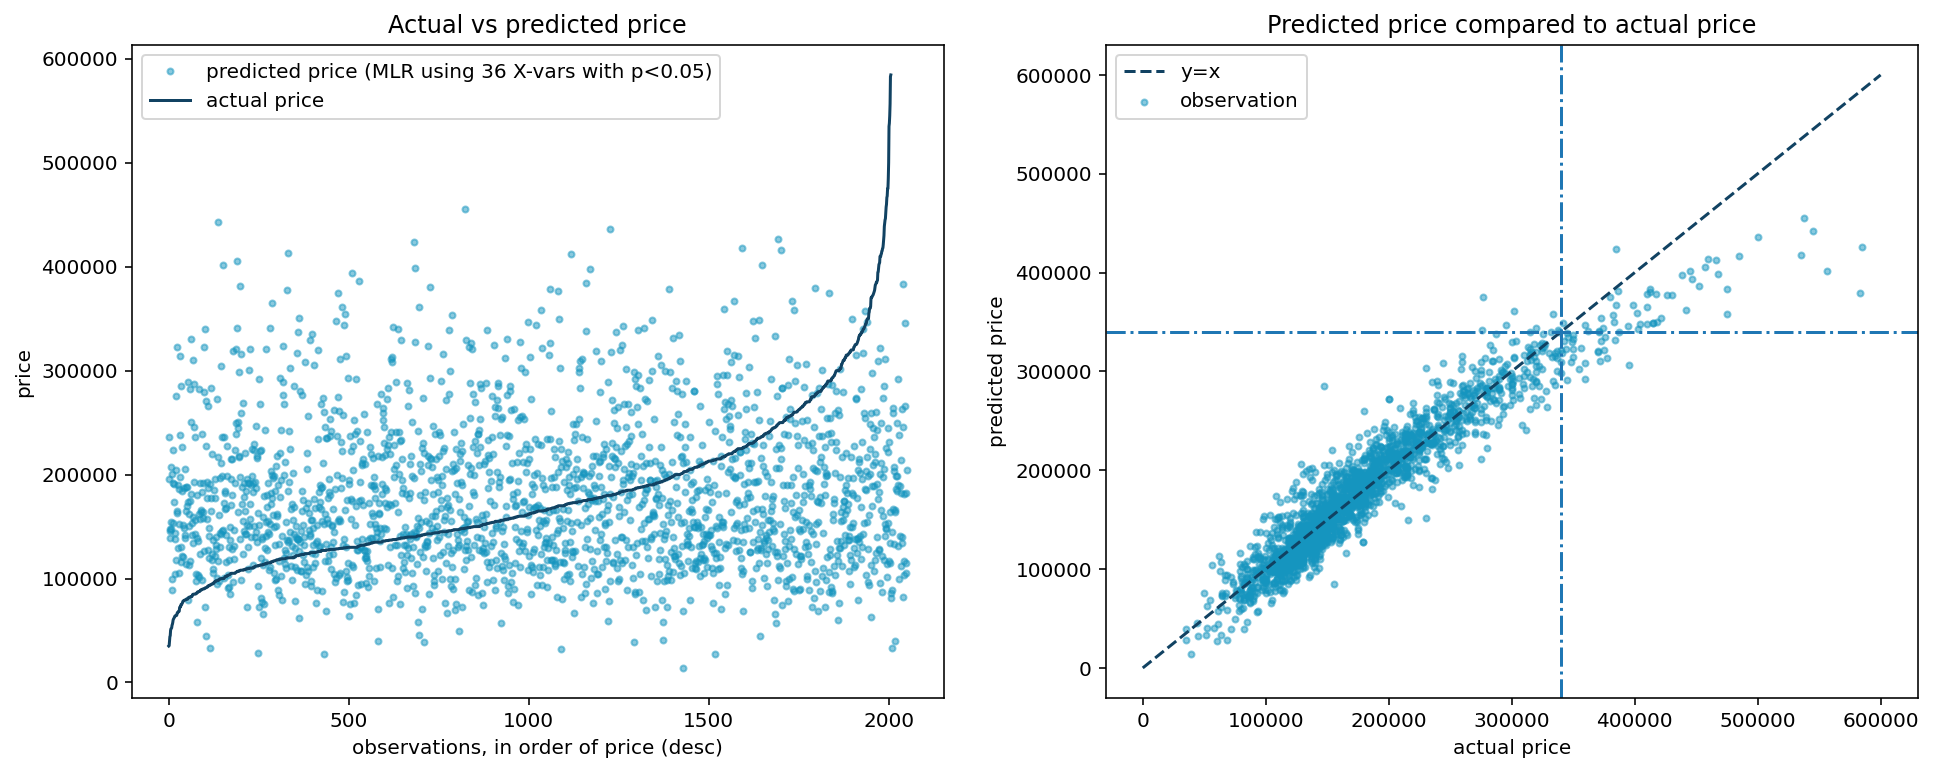

In [72]:
mlr5_pred = pd.DataFrame(y.T)
mlr5_pred['PredPrice'] = mlr_5.predict(X_five)
mlr5_pred = mlr5_pred.sort_values('SalePrice')

plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(mlr5_pred.index, mlr5_pred['PredPrice'], color = '#1595bf', ls = '', marker = ".", alpha = 0.5, label = 'predicted price (MLR using 36 X-vars with p<0.05)')
plt.plot(range(0, len(mlr5_pred)), mlr5_pred['SalePrice'], color = '#114262ff', label = 'actual price')
#plt.scatter(mlr1_pred['Gr Liv Area'], mlr1_pred['SalePrice'], color = '#1595bfff', marker = ".", alpha = 0.5)
plt.xlabel('observations, in order of price (desc)')
plt.ylabel('price')
plt.title('Actual vs predicted price')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(mlr5_pred['SalePrice'], mlr5_pred['PredPrice'], color = '#1595bf', marker = ".", alpha = 0.5, label = 'observation')
plt.plot([0,600000], [0,600000], color = '#114262ff', ls = '--', label = 'y=x')
plt.axhline(340000, ls = '-.')
plt.axvline(340000, ls = '-.')
plt.xlabel('actual price')
plt.ylabel('predicted price')
plt.title('Predicted price compared to actual price')
plt.legend()

plt.savefig('./visualizations/mlr5');

**_Observation:_** The model seems to perform well on properties priced below $340,000 but very poorly on those that are more expensive than that. 

#### 4.5. Model Iteration #5

**Regularization with Ridge**

Finding optimal alpha for Ridge using Gridsearch:

In [73]:
pipe_ridge = Pipeline([('ridge', Ridge())])

pipe_r_params = {'ridge__alpha': list(np.logspace(0, 100, 500))}

pipe_gridsearch = GridSearchCV(pipe_ridge,pipe_r_params, cv=5,verbose=1)

gridsearch_results = pipe_gridsearch.fit(X_five, y)
best_ridge_est = gridsearch_results.best_estimator_

print(f"The best score of {gridsearch_results.best_score_} is achieved by {best_ridge_est}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best score of 0.8936649233958465 is achieved by Pipeline(steps=[('ridge', Ridge(alpha=2.516527051405392))])


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   13.4s finished


Fitting the model:

In [74]:
best_ridge_est.fit(X_train_5, y_train_5)

print(f"R2 on training data = {best_ridge_est.score(X_train_5, y_train_5).round(4)}")
print(f"R2 on test data = {best_ridge_est.score(X_test_5, y_test_5).round(4)}")
print(f"Average R2 in 5-fold cross-validation = {cross_val_score(best_ridge_est, X_five, y).mean().round(4)} (std of {cross_val_score(best_ridge_est, X_five, y).std().round(4)})")

R2 on training data = 0.9019
R2 on test data = 0.8926
Average R2 in 5-fold cross-validation = 0.8937 (std of 0.0071)


**Visualization of results**

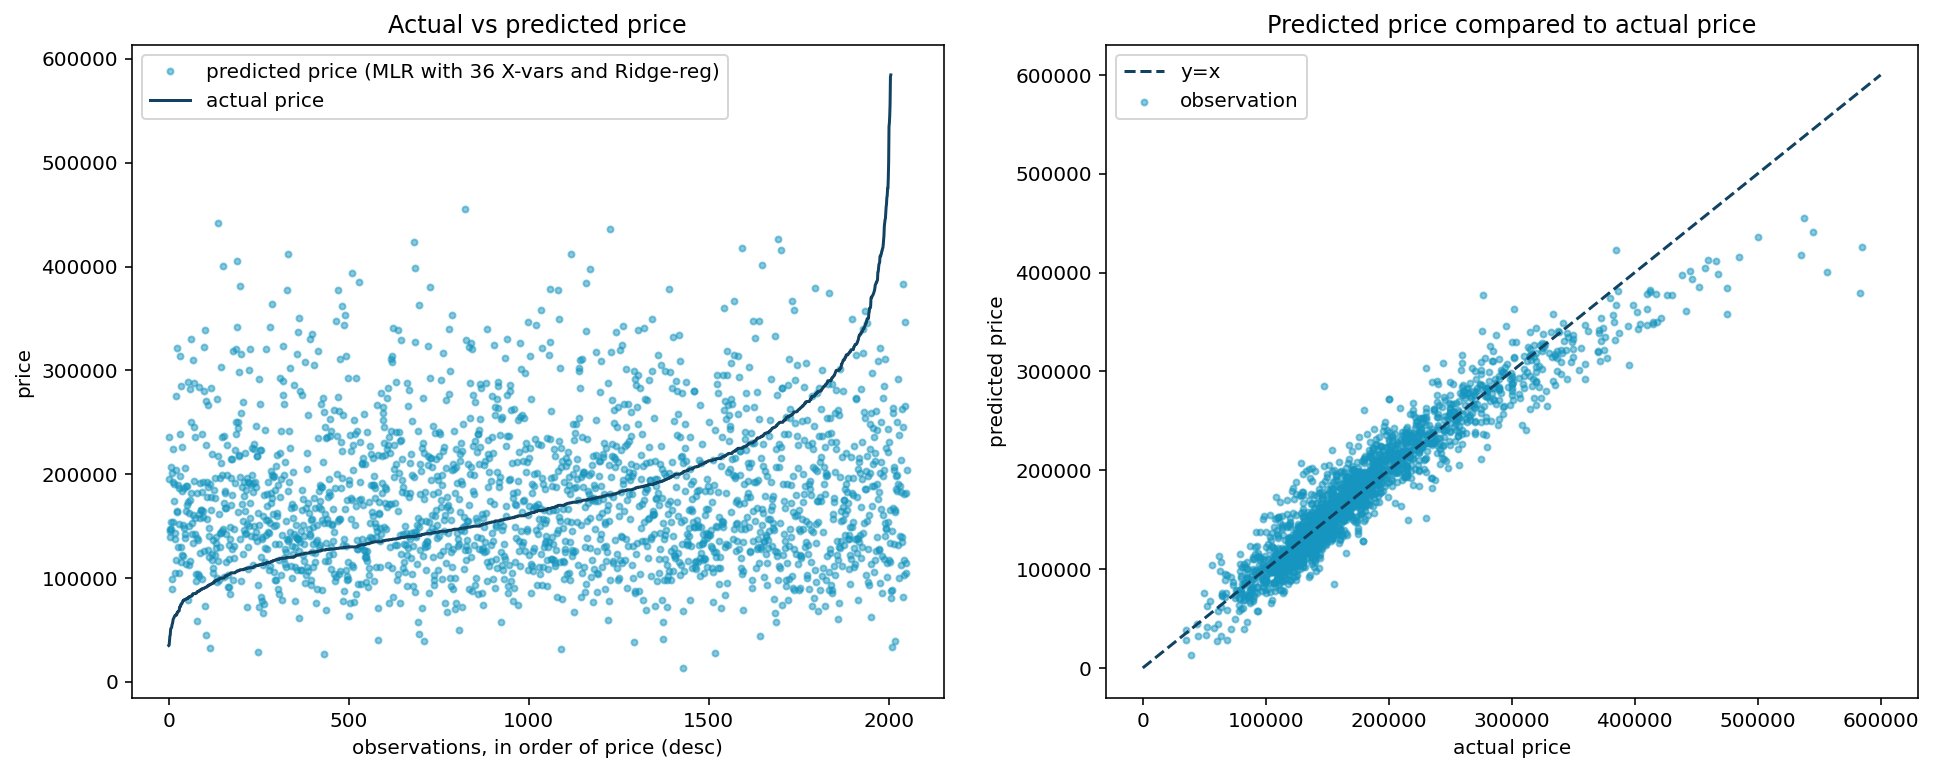

In [75]:
best_ridge_pred = pd.DataFrame(y.T)
best_ridge_pred['PredPrice'] = best_ridge_est.predict(X_five)
best_ridge_pred = best_ridge_pred.sort_values('SalePrice')

plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(best_ridge_pred.index, best_ridge_pred['PredPrice'], color = '#1595bf', ls = '', marker = ".", alpha = 0.5, label = 'predicted price (MLR with 36 X-vars and Ridge-reg)')
plt.plot(range(0, len(best_ridge_pred)), best_ridge_pred['SalePrice'], color = '#114262ff', label = 'actual price')
#plt.scatter(mlr1_pred['Gr Liv Area'], mlr1_pred['SalePrice'], color = '#1595bfff', marker = ".", alpha = 0.5)
plt.xlabel('observations, in order of price (desc)')
plt.ylabel('price')
plt.title('Actual vs predicted price')
plt.legend()
plt.subplot(1,2,2)
plt.scatter(best_ridge_pred['SalePrice'], best_ridge_pred['PredPrice'], color = '#1595bf', marker = ".", alpha = 0.5, label = 'observation')
plt.plot([0,600000], [0,600000], color = '#114262ff', ls = '--', label = 'y=x')
plt.xlabel('actual price')
plt.ylabel('predicted price')
plt.title('Predicted price compared to actual price')
plt.legend()

plt.savefig('./visualizations/best_ridge');

#### 4.6. Model Iteration #6

**Regularization with Lasso**

Finding optimal alpha (lambda) for Lasso regularization using Gridsearch and fitting the model:

In [76]:
pipe_lasso = Pipeline([('lasso', Lasso())])
pipe_l_params = {'lasso__alpha': list(np.logspace(0, 100, 500))}
pipe_gridsearch = GridSearchCV(pipe_lasso,pipe_l_params, cv=5,verbose=1)

gridsearch_results = pipe_gridsearch.fit(X_five, y)
best_lasso_est = gridsearch_results.best_estimator_

print(f"The best score of {gridsearch_results.best_score_} is achieved by {best_lasso_est}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121990712010.66309, tolerance: 874399450.2407168
  model = cd_fast.enet_coordinate_descent(
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134771128102.85895, tolerance: 900484083.7501028
  model = cd_fast.enet_coordinate_descent(
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132834482706.86945, tolerance: 876090837.1106999
  model = cd_fast.enet_coordinate_d

The best score of 0.8936398255106186 is achieved by Pipeline(steps=[('lasso', Lasso())])


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   23.7s finished
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162967132569.68, tolerance: 1104161739.6832893
  model = cd_fast.enet_coordinate_descent(


In [77]:
best_lasso_est.fit(X_train_5, y_train_5)

print(f"R2 on training data = {best_lasso_est.score(X_train_5, y_train_5).round(4)}")
print(f"R2 on test data = {best_lasso_est.score(X_test_5, y_test_5).round(4)}")
print(f"Average R2 in 5-fold cross-validation = {cross_val_score(best_lasso_est, X_five, y).mean().round(4)} (std of {cross_val_score(best_lasso_est, X_five, y).std().round(4)})")

/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114891117701.68079, tolerance: 826696170.4518204
  model = cd_fast.enet_coordinate_descent(
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121990712010.66309, tolerance: 874399450.2407168
  model = cd_fast.enet_coordinate_descent(


R2 on training data = 0.9019
R2 on test data = 0.8928


/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134771128102.85895, tolerance: 900484083.7501028
  model = cd_fast.enet_coordinate_descent(
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132834482706.86945, tolerance: 876090837.1106999
  model = cd_fast.enet_coordinate_descent(
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130309675622.24786, tolerance: 891447665.8601457
  model = cd_fast.enet_coordinate_descent(
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_mode

Average R2 in 5-fold cross-validation = 0.8936 (std of 0.0068)


/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130309675622.24786, tolerance: 891447665.8601457
  model = cd_fast.enet_coordinate_descent(
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127281622658.07385, tolerance: 873828058.2637641
  model = cd_fast.enet_coordinate_descent(


**Visualization of results**

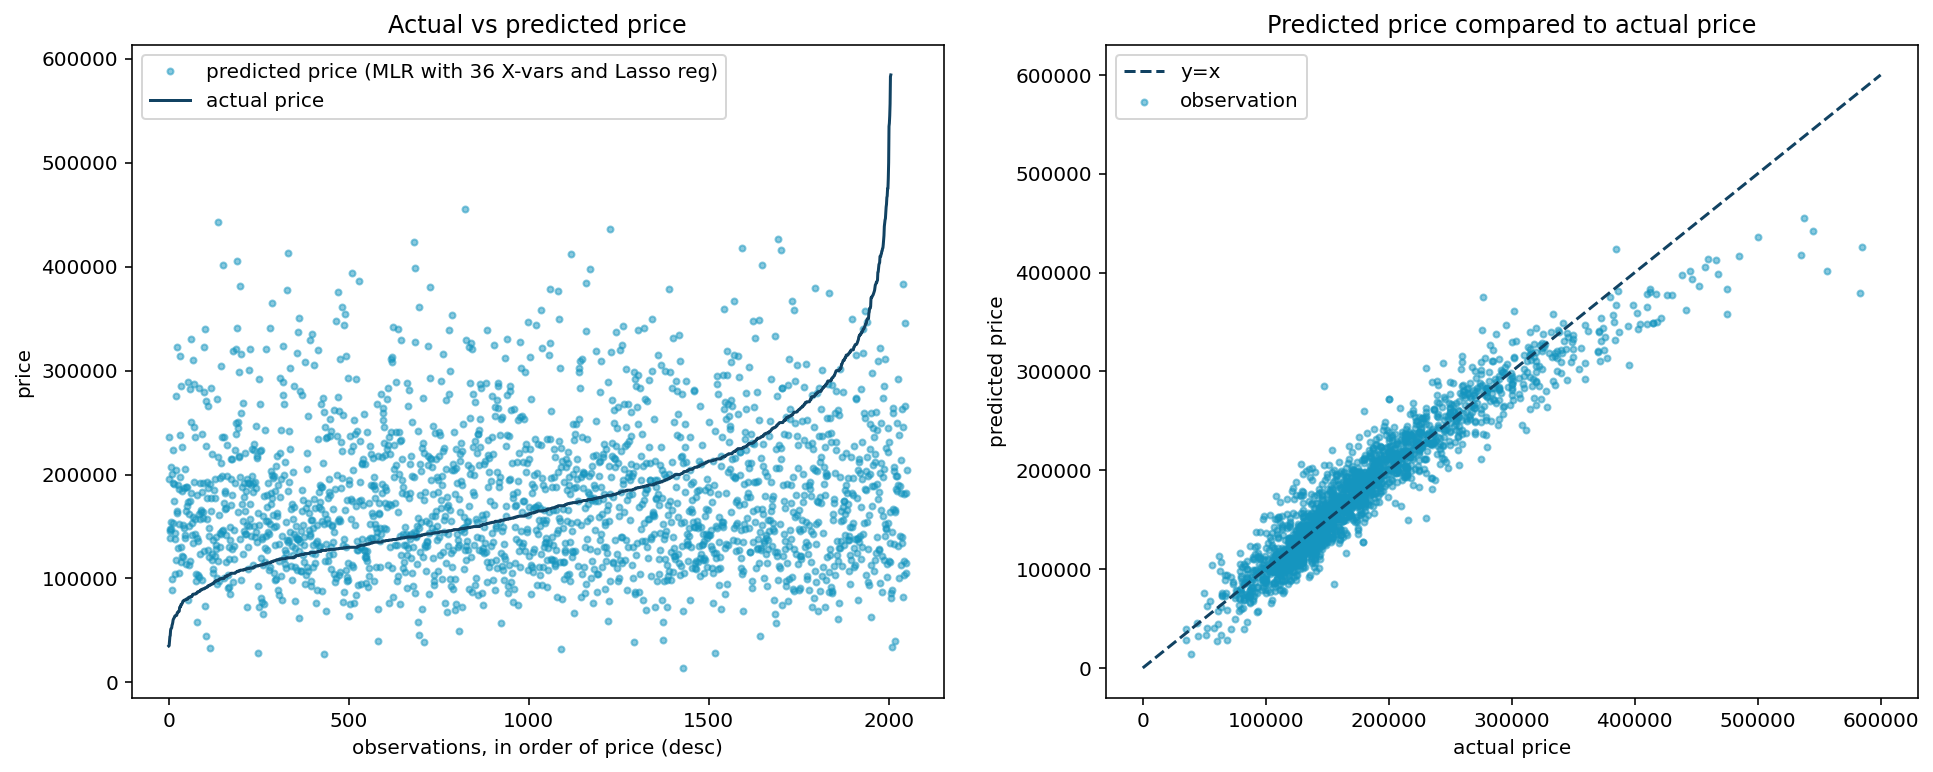

In [78]:
best_lasso_pred = pd.DataFrame(y.T)
best_lasso_pred['PredPrice'] = best_lasso_est.predict(X_five)
best_lasso_pred = best_lasso_pred.sort_values('SalePrice')

plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(best_lasso_pred.index, best_lasso_pred['PredPrice'], color = '#1595bf', ls = '', marker = ".", alpha = 0.5, label = 'predicted price (MLR with 36 X-vars and Lasso reg)')
plt.plot(range(0, len(best_lasso_pred)), best_lasso_pred['SalePrice'], color = '#114262ff', label = 'actual price')
#plt.scatter(mlr1_pred['Gr Liv Area'], mlr1_pred['SalePrice'], color = '#1595bfff', marker = ".", alpha = 0.5)
plt.xlabel('observations, in order of price (desc)')
plt.ylabel('price')
plt.title('Actual vs predicted price')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(best_lasso_pred['SalePrice'], best_lasso_pred['PredPrice'], color = '#1595bf', marker = ".", alpha = 0.5, label = 'observation')
plt.plot([0,600000], [0,600000], color = '#114262ff', ls = '--', label = 'y=x')
plt.xlabel('actual price')
plt.ylabel('predicted price')
plt.title('Predicted price compared to actual price')
plt.legend()

plt.savefig('./visualizations/best_lasso');

## Part 5: Predictions

#### Confirming normal distribution of residuals

H0 (null hypothesis): Residuals resulting from using the best model follow a normal distribution
H1 (alternative hypothesis): Residuals resulting from using the best model do not follow a normal distribution

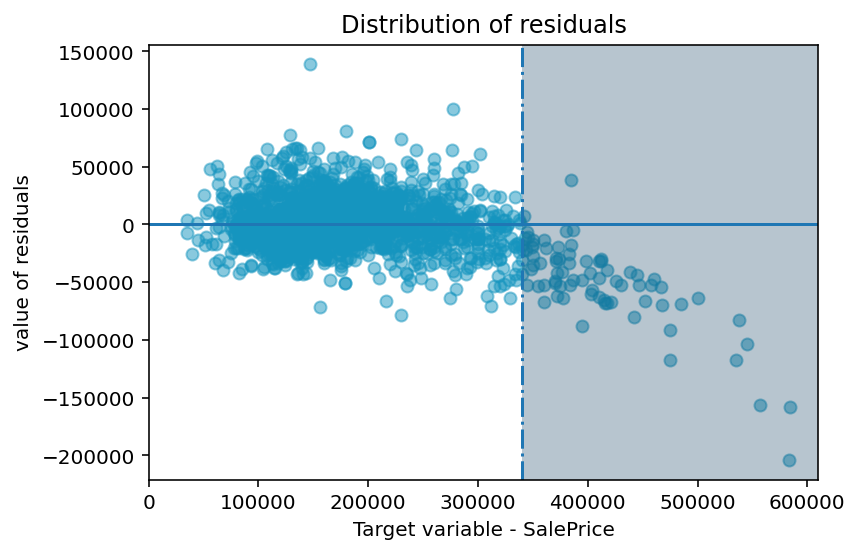

In [79]:
resids = best_ridge_est.predict(X_five) - y

plt.scatter(y, resids, color =  '#1595bfff', alpha = 0.5)
plt.title('Distribution of residuals')
plt.xlabel('Target variable - SalePrice')
plt.axvline(340000, ls = '-.')
plt.axvspan(340000,620000,facecolor='#114262ff', alpha=0.3 )
plt.xlim(0,610000)
plt.axhline(0)
plt.ylabel('value of residuals');

In [80]:
resids = best_ridge_est.predict(X_five) - y
stat, p = kstest(resids, 'norm')

if p < 0.05:
    print(f"Based on the value of p = {p.round(2)}, we have to reject the null hypothesis.")
else:
    print(f"Based on the value of p = {p.round(2)}, there isn't sufficient evidence to reject the null hypothesis.")

Based on the value of p = 0.0, we have to reject the null hypothesis.


**_Note:_** As previously observed, the model performs poor on observations with `SalePrice`>340,000. However, the distribution of residuals does appear to be approximately normal for the 96% of observations below that threshold.


#### 5.1 Performing all cleaning and feature engineering steps on "test data"

The code below reproduces steps defined and executed in Part 3 (Feature Engineering) on "test data" to prepare it for application of the estimator

In [81]:
test_data['Bathrooms'] = test_data['Full Bath'] + 0.5 * test_data['Half Bath']
test_data['Pool'] = test_data['Pool Area'].apply(lambda x: 1 if x > 0 else 0)
test_data['Yrs Since Constr or Remod'] = test_data['Yr Sold'] - test_data['Year Remod/Add']
test_data['HQ SF'] = test_data['Gr Liv Area'] - test_data['Low Qual Fin SF']

test_data['Heating QC'] = test_data['Heating QC'].map(five_scale_map)
test_data['Kitchen Qual'] = test_data['Kitchen Qual'].map(five_scale_map)
test_data['Exter Qual'] = test_data['Exter Qual'].map(five_scale_map)
test_data['Exter Cond'] = test_data['Exter Cond'].map(five_scale_map)
test_data['Exter Qual x Cond'] = test_data['Exter Qual']*test_data['Exter Cond']

test_data['Garage Qual'] = test_data['Garage Qual'].map(six_scale_map)
test_data['Garage Cond'] = test_data['Garage Cond'].map(six_scale_map)
test_data['Garage Qual x Cond'] = test_data['Garage Qual']*test_data['Garage Cond']
test_data['Garage Qual x Cond'].fillna(0, inplace = True)
test_data['Garage Qual'].fillna(0, inplace = True)
test_data['Garage Cond'].fillna(0, inplace = True)

test_data['Bsmt Qual'] = test_data['Bsmt Qual'].map(six_scale_map)
test_data['Bsmt Cond'] = test_data['Bsmt Cond'].map(six_scale_map)
test_data['Bsmt Qual x Cond'] = test_data['Bsmt Qual']*test_data['Bsmt Cond']
test_data['Bsmt Qual x Cond'].fillna(0, inplace = True)
test_data['Bsmt Qual'].fillna(0, inplace = True)
test_data['Bsmt Cond'].fillna(0, inplace = True)

test_data['Fireplace Qu'] = test_data['Fireplace Qu'].map(five_scale_map)
test_data['Fireplace Qu'].fillna(0, inplace = True)

test_data['Year Sold'] = test_data['Yr Sold']
test_data['Proximity to Pos Feat'] = test_data['Condition 1'].apply(lambda x: 1 if x == 'PosN' or x == 'PosA' else 0) +test_data['Condition 2'].apply(lambda x: 1 if x == 'PosN' or x == 'PosA' else 0)
test_data['Inflation Multiplier'] = test_data['Year Sold']-train_data['Year Sold'].min()

test_data['Good Nhood'] = test_data['Neighborhood'].apply(good_nhood)

test_data['Pref House Style'] = test_data['House Style'].apply(lambda x: 1 if x == '2Story' or x == '1Story' else 0)
test_data['Pref Garage Type'] = test_data['Garage Type'].apply(lambda x: 1 if x == 'Attchd' or x == 'BuiltIn' else 0)
test_data['Pref Mas Vnr'] = test_data['Mas Vnr Type'].apply(lambda x: 1 if x == 'BrkFace' or x == 'Stone' else 0)
test_data['Sold as New'] = test_data['Sale Type'].apply(lambda x: 1 if x == 'New' else 0)
test_data['Gtl Land Slope'] = test_data['Land Slope'].apply(lambda x: 1 if x == 'Gtl' else 0)
test_data['Pref Lot Config'] = test_data['Lot Config'].apply(lambda x: 1 if x == 'CulDSac' or x == 'Inside' else 0)
test_data['Zone RL'] = test_data['MS Zoning'].apply(lambda x: 1 if x == 'RL' else 0)

test_data = pd.get_dummies(test_data, drop_first=False, columns = ['MS SubClass','Yr Sold','Electrical', 'Central Air', 'Roof Style','Bldg Type', 'Functional', 'Foundation', 'Exterior 1st','Paved Drive'])

test_data['Mas Vnr Area'].fillna(train_data['Mas Vnr Area'].mean(), inplace= True)
test_data['Garage Cars'].fillna(0, inplace = True)
test_data['Garage Area'].fillna(0, inplace = True)
test_data['Lot Frontage'].fillna(0, inplace = True)

test_data.to_csv('./clean_data/test_data_cleaned.csv')

#### 5.2 Selecting the best estimator based on cross-validation score

In [82]:
estimators = [mlr_5, best_ridge_est, best_lasso_est]
best_est = lr_base #baseline

for est in estimators:
    if cross_val_score(est, X_five, y).mean() > cross_val_score(best_est, X_five, y).mean():
        best_est = est

best_est

/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121990712010.66309, tolerance: 874399450.2407168
  model = cd_fast.enet_coordinate_descent(
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134771128102.85895, tolerance: 900484083.7501028
  model = cd_fast.enet_coordinate_descent(
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132834482706.86945, tolerance: 876090837.1106999
  model = cd_fast.enet_coordinate_descent(
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_mode

Pipeline(steps=[('ridge', Ridge(alpha=2.516527051405392))])

#### 5.3 Creating scaled X variables from "test data"

In [83]:
X_five_test = test_data[X_5]

X_5_test_bin = [col for col in X_5 if test_data[col].dtype == 'uint8'] # binary vars
X_5_test_other = [col for col in X_5 if test_data[col].dtype != 'uint8'] #non-binary vars

X_five_test_bin = test_data[X_5_bin]
X_five_test_other = test_data[X_5_other]

scaler = StandardScaler()
X_five_test_other_sc = scaler.fit_transform(X_five_test_other)
X_five_test_other_sc_df = pd.DataFrame(data = X_five_test_other_sc, columns = X_5_other)
X_five_test = pd.concat([X_five_test_other_sc_df,X_five_test_bin.reset_index(drop=True)], axis = 1)

####  5.4 Applying the best model to "test data" and formatting submission file

In [84]:
best_est_preds = best_est.predict(X_five_test)
test_data['SalePrice'] = best_est_preds
submission = test_data[['Id', 'SalePrice']].copy()
submission.head()

Id      SalePrice
0  2658  163004.363854
1  2718  166507.875989
2  2414  206930.340549
3  1989  106783.385759
4   625  174600.432706

In [85]:
#submission.to_csv('./datasets/submission_10.csv', index = False)